In [ ]:
import pandas as pd
import pmdarima as pm
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.1 MB/s eta 0:00:00


In [ ]:
df=pd.read_csv("/content/company2.csv")
df

Date  Store  Dept  Weekly_Sales  IsHoliday
0     2010-02-05      1     1      17426.75      False
1     2010-02-12      1     1      37734.82       True
2     2010-02-19      1     1      22135.29      False
3     2010-02-26      1     1      14942.21      False
4     2010-03-05      1     1      17098.49      False
...          ...    ...   ...           ...        ...
6001  2012-09-28      7     6       1485.96      False
6002  2012-10-05      7     6       3412.10      False
6003  2012-10-12      7     6       4082.41      False
6004  2012-10-19      7     6       3874.78      False
6005  2012-10-26      7     6       3212.84      False

[6006 rows x 5 columns]

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [ ]:
def forecast_sales(dataset, col1, val1, col2, val2, forecast_periods=26):
    """
    Filters a dataset based on a specific column value and forecasts sales using auto ARIMA.

    Parameters:
    dataset (pd.DataFrame): The input dataset.
    column_name (str): The name of the column to filter on.
    desired_value (str or int): The value to filter the column by.
    forecast_periods (int): Number of periods to forecast. Default is 26 weeks.

    Returns:
    pd.DataFrame: DataFrame containing the forecasted sales and confidence intervals.
    float: Root Mean Squared Error (RMSE) of the forecast.
    float: Mean Absolute Error (MAE) of the forecast.
    """
    # Filter the dataset
    filtered_df = dataset[(dataset[col1] == val1) & (dataset[col2] == val2)]

    # Ensure the dataframe is sorted by date
    filtered_df = filtered_df.sort_index()

    # Step 2: Find the best parameters for auto SARIMA using the auto_arima function
    auto_model = pm.auto_arima(filtered_df['Weekly_Sales'], seasonal=True, m=52, stepwise=True, trace=True,
                               max_order=None, max_d=2, max_p=5, max_q=5, max_P=3, max_Q=3)

    # Step 3: Fit the model to the data
    auto_model.fit(filtered_df['Weekly_Sales'])

    # Step 4: Make predictions for the next forecast_periods
    forecast, conf_int = auto_model.predict(n_periods=forecast_periods, return_conf_int=True)

    # Create a date range for the forecast period
    last_date = filtered_df.index[-1]
    date_range = pd.date_range(last_date + timedelta(weeks=1), periods=forecast_periods, freq='W')

    # Create a DataFrame to store the forecasts
    forecast_df = pd.DataFrame({'Date': date_range, 'Weekly_Sales_Forecast': forecast,
                                'Lower_CI': conf_int[:, 0], 'Upper_CI': conf_int[:, 1]})
    forecast_df.set_index('Date', inplace=True)

    # Display the forecasted sales for the forecast period
    print("Forecasted sales for the next period:")
    print(forecast_df)

    # Step 5: Evaluate the model's performance using RMSE and MAE on the filtered dataset
    actual_values = filtered_df['Weekly_Sales']
    min_len = min(len(actual_values), len(forecast))  # Ensure lengths match for comparison
    rmse = np.sqrt(mean_squared_error(actual_values[:min_len], forecast[:min_len]))
    mae = mean_absolute_error(actual_values[:min_len], forecast[:min_len])
    print("Root Mean Squared Error (RMSE) on the full dataset:", rmse)
    print("Mean Absolute Error (MAE) on the full dataset:", mae)

    # Plotting full forecast, historical weekly sales, and confidence intervals on the same plot
    plt.figure(figsize=(12, 6))
    plt.plot(filtered_df.index, filtered_df['Weekly_Sales'], label='Historical Weekly Sales')
    plt.plot(forecast_df.index, forecast_df['Weekly_Sales_Forecast'], label='Full Forecast', color='orange')

    # Fill the area between the confidence intervals
    plt.fill_between(forecast_df.index, forecast_df['Lower_CI'], forecast_df['Upper_CI'], color='orange', alpha=0.2, label='Confidence Intervals')

    plt.title('Historical Weekly Sales and Full Forecast')
    plt.xlabel('Date')
    plt.ylabel('Weekly Sales')
    plt.legend()
    plt.grid(True)
    plt.show()

    return forecast_df, rmse, mae

# Example usage
# Assuming df is your DataFrame with 'Weekly_Sales' and a specific column to filter by
# dataset = pd.read_csv('your_dataset.csv', index_col='Date', parse_dates=True)
# forecast_df, rmse, mae = forecast_sales(dataset, 'Store', 'desired_store_value')

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=2967.604, Time=4.53 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=3021.188, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=2975.125, Time=1.66 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=2968.011, Time=1.93 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=3234.972, Time=0.06 sec
 ARIMA(2,0,2)(0,0,1)[52] intercept   : AIC=2968.428, Time=2.72 sec
 ARIMA(2,0,2)(1,0,0)[52] intercept   : AIC=2965.732, Time=4.34 sec
 ARIMA(2,0,2)(0,0,0)[52] intercept   : AIC=2984.463, Time=0.13 sec
 ARIMA(2,0,2)(2,0,0)[52] intercept   : AIC=2967.696, Time=12.97 sec
 ARIMA(2,0,2)(2,0,1)[52] intercept   : AIC=inf, Time=29.57 sec
 ARIMA(1,0,2)(1,0,0)[52] intercept   : AIC=2965.181, Time=3.24 sec
 ARIMA(1,0,2)(0,0,0)[52] intercept   : AIC=2983.155, Time=0.20 sec
 ARIMA(1,0,2)(2,0,0)[52] intercept   : AIC=2967.070, Time=10.83 sec
 ARIMA(1,0,2)(1,0,1)[52] intercept   : AIC=2967.010, Time=4.25 sec
 ARIMA(1,0,2)(0,0,1)[

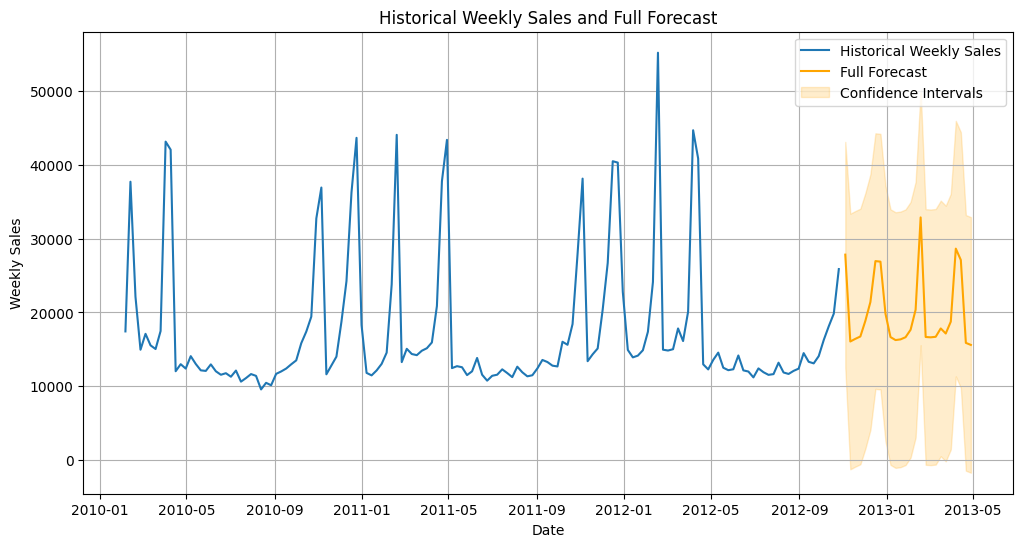

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=2730.648, Time=10.70 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=2756.894, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=2735.182, Time=0.96 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=2738.257, Time=0.86 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=2754.897, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[52] intercept   : AIC=2737.959, Time=9.19 sec
 ARIMA(2,1,2)(1,0,0)[52] intercept   : AIC=2733.602, Time=7.81 sec
 ARIMA(2,1,2)(2,0,1)[52] intercept   : AIC=2732.204, Time=45.51 sec
 ARIMA(2,1,2)(1,0,2)[52] intercept   : AIC=2732.204, Time=43.27 sec
 ARIMA(2,1,2)(0,0,0)[52] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(2,1,2)(0,0,2)[52] intercept   : AIC=2730.205, Time=28.44 sec
 ARIMA(2,1,2)(0,0,3)[52] intercept   : AIC=2732.180, Time=91.75 sec
 ARIMA(2,1,2)(1,0,3)[52] intercept   : AIC=2734.184, Time=103.56 sec
 ARIMA(1,1,2)(0,0,2)[52] intercept   : AIC=2733.938, Time=20.09 sec
 ARIMA(2,1,1)(0,

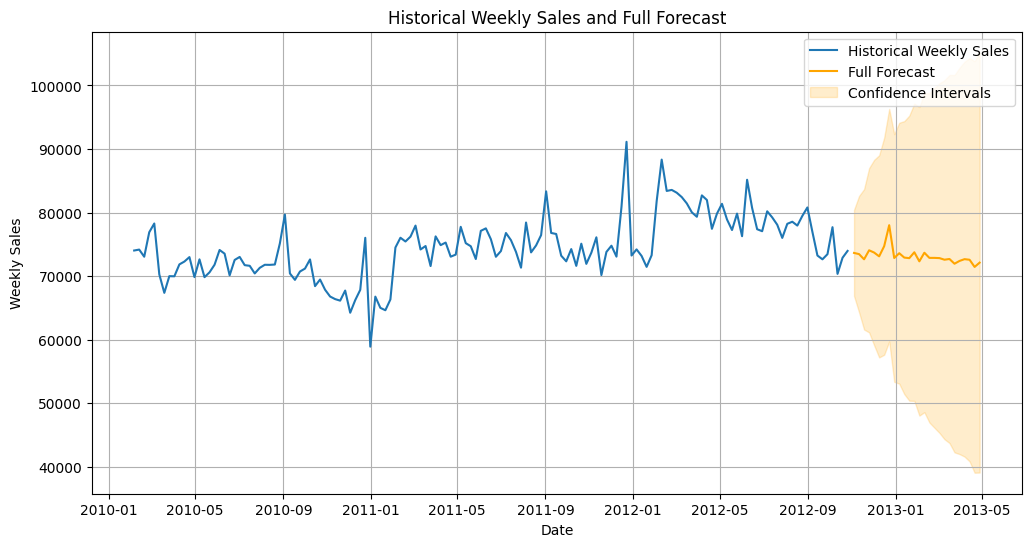

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[52]             : AIC=inf, Time=23.31 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=1631.517, Time=0.67 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=1627.792, Time=2.36 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=1627.052, Time=2.86 sec
 ARIMA(0,1,1)(0,1,0)[52]             : AIC=1630.862, Time=0.41 sec
 ARIMA(0,1,1)(1,1,1)[52]             : AIC=inf, Time=8.52 sec
 ARIMA(0,1,1)(0,1,2)[52]             : AIC=1624.229, Time=10.06 sec
 ARIMA(0,1,1)(1,1,2)[52]             : AIC=1626.227, Time=16.73 sec
 ARIMA(0,1,1)(0,1,3)[52]             : AIC=1626.225, Time=37.20 sec
 ARIMA(0,1,1)(1,1,3)[52]             : AIC=1628.225, Time=45.85 sec
 ARIMA(0,1,0)(0,1,2)[52]             : AIC=1628.829, Time=7.12 sec
 ARIMA(1,1,1)(0,1,2)[52]             : AIC=1622.629, Time=22.63 sec
 ARIMA(1,1,1)(0,1,1)[52]             : AIC=1625.026, Time=6.07 sec
 ARIMA(1,1,1)(1,1,2)[52]             : AIC=1624.623, Time=63.17 sec
 ARIMA(1,1,1)(0,1,3)[5

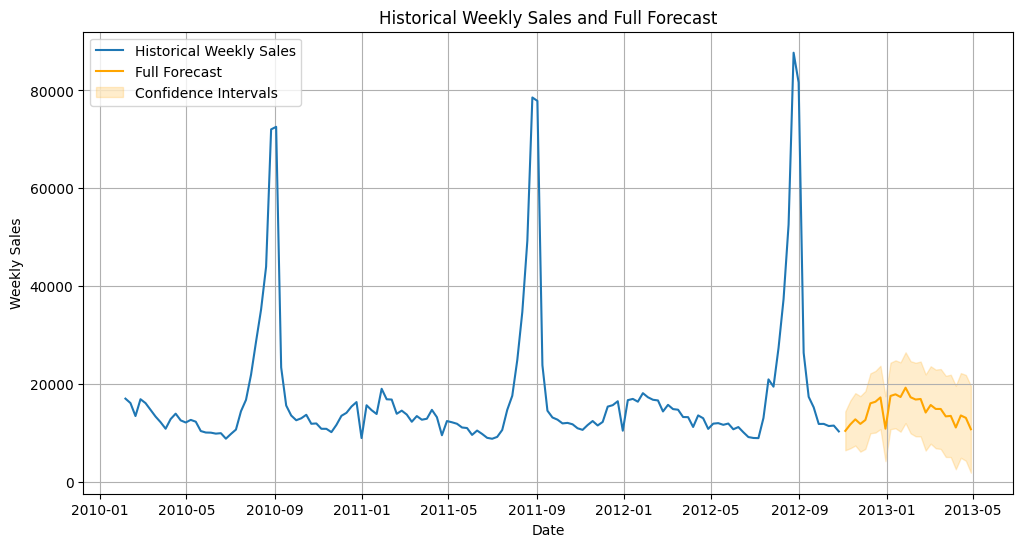

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=2504.267, Time=12.32 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=2559.749, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=2505.227, Time=2.53 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=2516.556, Time=2.64 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=2557.760, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[52] intercept   : AIC=2510.842, Time=8.24 sec
 ARIMA(2,1,2)(1,0,0)[52] intercept   : AIC=2496.514, Time=7.86 sec
 ARIMA(2,1,2)(0,0,0)[52] intercept   : AIC=2543.387, Time=0.19 sec
 ARIMA(2,1,2)(2,0,0)[52] intercept   : AIC=2498.261, Time=38.69 sec
 ARIMA(2,1,2)(2,0,1)[52] intercept   : AIC=inf, Time=47.31 sec
 ARIMA(1,1,2)(1,0,0)[52] intercept   : AIC=2495.176, Time=6.26 sec
 ARIMA(1,1,2)(0,0,0)[52] intercept   : AIC=2541.517, Time=0.28 sec
 ARIMA(1,1,2)(2,0,0)[52] intercept   : AIC=2494.173, Time=33.86 sec
 ARIMA(1,1,2)(3,0,0)[52] intercept   : AIC=2496.247, Time=96.50 sec
 ARIMA(1,1,2)(2,0,1

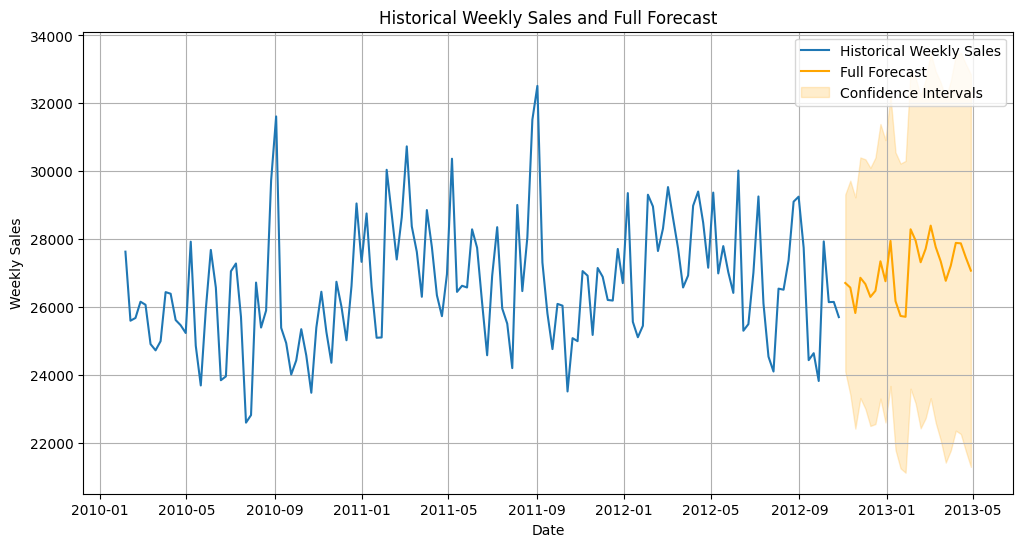

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=3057.085, Time=4.89 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=3148.130, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=3080.248, Time=1.51 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=3098.614, Time=0.80 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=3368.000, Time=0.04 sec
 ARIMA(2,0,2)(0,0,1)[52] intercept   : AIC=3067.928, Time=2.54 sec
 ARIMA(2,0,2)(1,0,0)[52] intercept   : AIC=3055.085, Time=3.02 sec
 ARIMA(2,0,2)(0,0,0)[52] intercept   : AIC=3105.458, Time=0.16 sec
 ARIMA(2,0,2)(2,0,0)[52] intercept   : AIC=3057.061, Time=22.54 sec
 ARIMA(2,0,2)(2,0,1)[52] intercept   : AIC=3058.770, Time=20.08 sec
 ARIMA(1,0,2)(1,0,0)[52] intercept   : AIC=3063.533, Time=3.88 sec
 ARIMA(2,0,1)(1,0,0)[52] intercept   : AIC=3059.097, Time=2.54 sec
 ARIMA(3,0,2)(1,0,0)[52] intercept   : AIC=3055.920, Time=4.64 sec
 ARIMA(2,0,3)(1,0,0)[52] intercept   : AIC=3062.727, Time=3.78 sec
 ARIMA(1,0,1)(1,0

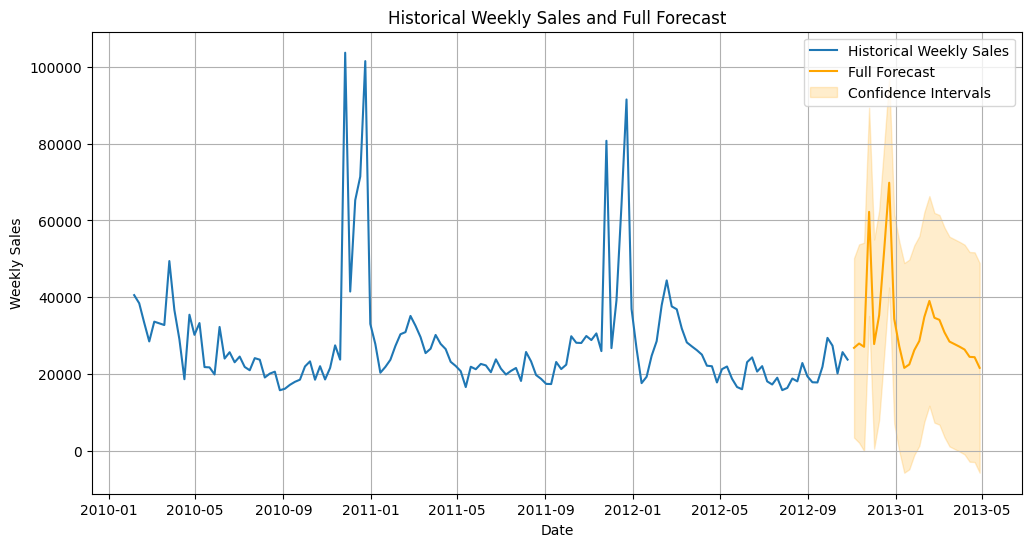

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=2695.850, Time=8.48 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=2819.266, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=inf, Time=5.17 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=inf, Time=4.93 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=2817.272, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[52] intercept   : AIC=inf, Time=8.90 sec
 ARIMA(2,1,2)(1,0,0)[52] intercept   : AIC=inf, Time=8.70 sec
 ARIMA(2,1,2)(2,0,1)[52] intercept   : AIC=inf, Time=55.14 sec
 ARIMA(2,1,2)(1,0,2)[52] intercept   : AIC=inf, Time=37.79 sec
 ARIMA(2,1,2)(0,0,0)[52] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(2,1,2)(0,0,2)[52] intercept   : AIC=inf, Time=41.18 sec
 ARIMA(2,1,2)(2,0,0)[52] intercept   : AIC=2705.714, Time=46.62 sec
 ARIMA(2,1,2)(2,0,2)[52] intercept   : AIC=inf, Time=46.59 sec
 ARIMA(1,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=9.06 sec
 ARIMA(2,1,1)(1,0,1)[52] intercept   : AIC=2691.044, Time=10.07 

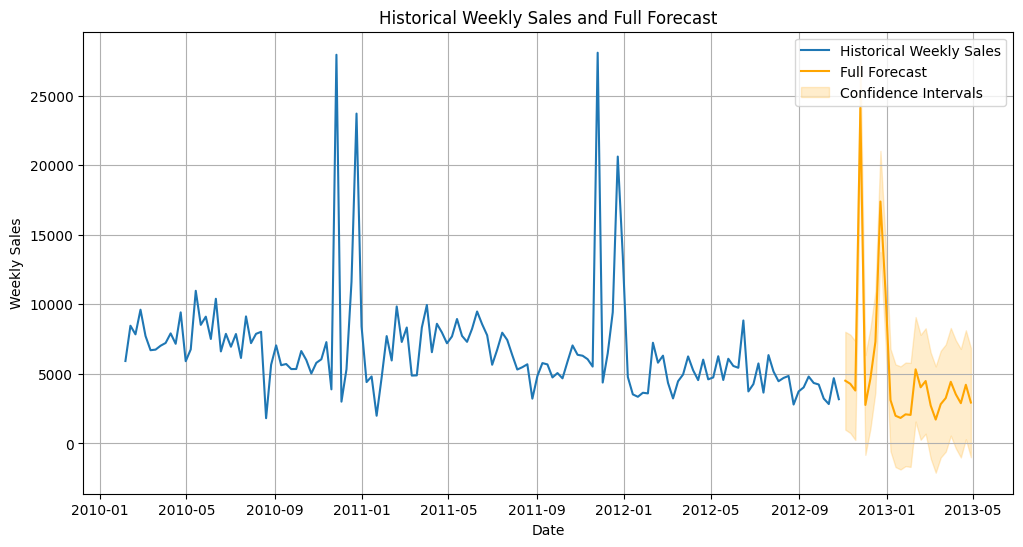

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=3277.115, Time=5.56 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=3337.933, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=3287.056, Time=1.06 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=3278.349, Time=1.00 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=3527.969, Time=0.03 sec
 ARIMA(2,0,2)(0,0,1)[52] intercept   : AIC=3276.193, Time=2.42 sec
 ARIMA(2,0,2)(0,0,0)[52] intercept   : AIC=3290.212, Time=0.12 sec
 ARIMA(2,0,2)(0,0,2)[52] intercept   : AIC=3276.121, Time=12.15 sec
 ARIMA(2,0,2)(1,0,2)[52] intercept   : AIC=3278.031, Time=23.88 sec
 ARIMA(2,0,2)(0,0,3)[52] intercept   : AIC=3277.664, Time=37.32 sec
 ARIMA(2,0,2)(1,0,3)[52] intercept   : AIC=3279.222, Time=70.85 sec
 ARIMA(1,0,2)(0,0,2)[52] intercept   : AIC=3277.213, Time=7.78 sec
 ARIMA(2,0,1)(0,0,2)[52] intercept   : AIC=3273.416, Time=9.56 sec
 ARIMA(2,0,1)(0,0,1)[52] intercept   : AIC=3273.541, Time=1.64 sec
 ARIMA(2,0,1)(1

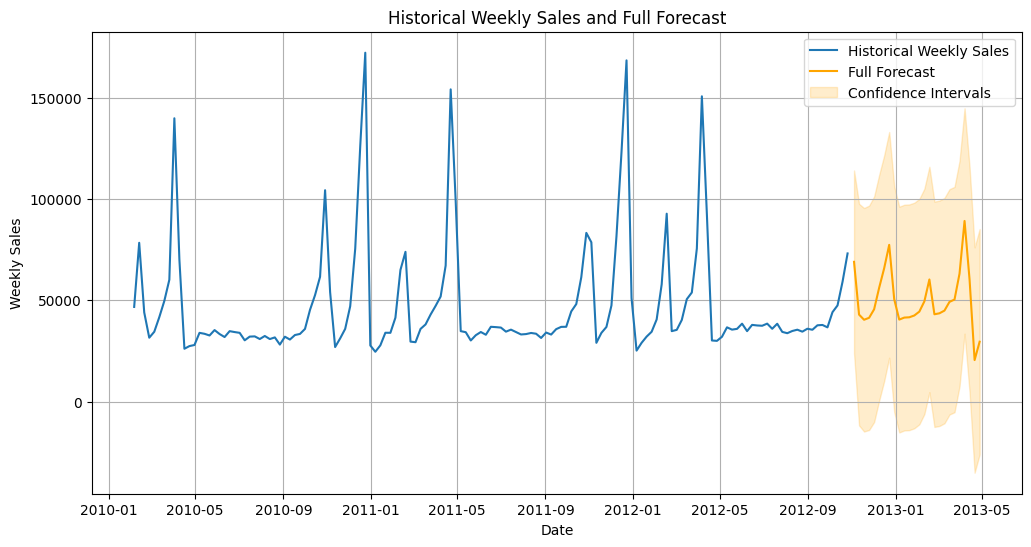

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[52] intercept   : AIC=1751.393, Time=34.41 sec
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=1746.363, Time=0.27 sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=1752.247, Time=6.59 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=1749.660, Time=8.61 sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=1775.075, Time=0.22 sec
 ARIMA(0,0,0)(1,1,0)[52] intercept   : AIC=1748.359, Time=1.66 sec
 ARIMA(0,0,0)(0,1,1)[52] intercept   : AIC=1748.358, Time=1.33 sec
 ARIMA(0,0,0)(1,1,1)[52] intercept   : AIC=1750.355, Time=8.01 sec
 ARIMA(1,0,0)(0,1,0)[52] intercept   : AIC=1751.523, Time=0.66 sec
 ARIMA(0,0,1)(0,1,0)[52] intercept   : AIC=1747.699, Time=0.51 sec
 ARIMA(1,0,1)(0,1,0)[52] intercept   : AIC=1750.916, Time=1.82 sec

Best model:  ARIMA(0,0,0)(0,1,0)[52] intercept
Total fit time: 64.158 seconds
Forecasted sales for the next period:
            Weekly_Sales_Forecast       Lower_CI       Upper_CI
Date                                  

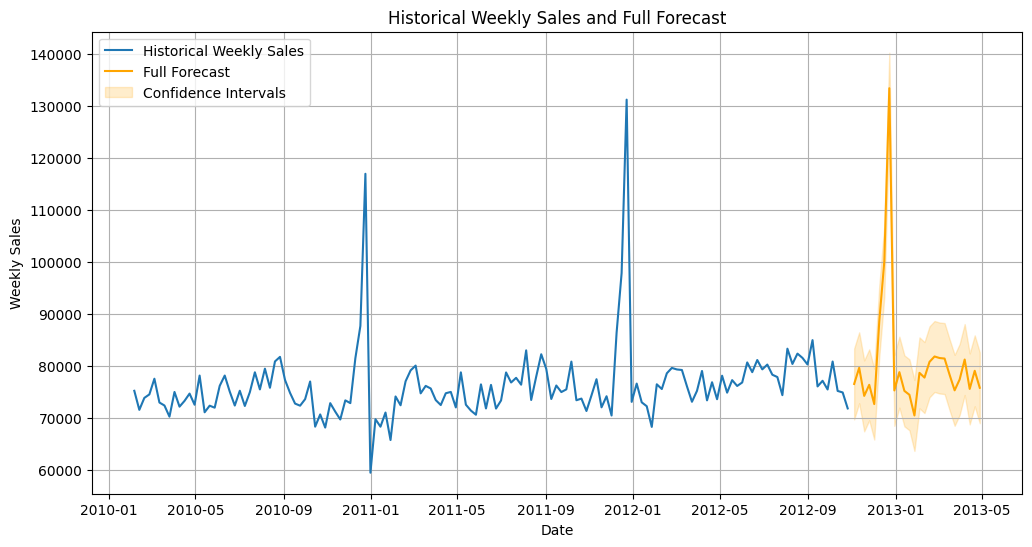

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=3094.512, Time=3.63 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=3238.095, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=3099.531, Time=1.31 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=inf, Time=5.58 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=3381.015, Time=0.03 sec
 ARIMA(2,0,2)(0,0,1)[52] intercept   : AIC=3096.249, Time=2.24 sec
 ARIMA(2,0,2)(1,0,0)[52] intercept   : AIC=3092.610, Time=4.60 sec
 ARIMA(2,0,2)(0,0,0)[52] intercept   : AIC=3119.909, Time=0.13 sec
 ARIMA(2,0,2)(2,0,0)[52] intercept   : AIC=3094.540, Time=11.86 sec
 ARIMA(2,0,2)(2,0,1)[52] intercept   : AIC=3096.426, Time=26.95 sec
 ARIMA(1,0,2)(1,0,0)[52] intercept   : AIC=3090.785, Time=3.45 sec
 ARIMA(1,0,2)(0,0,0)[52] intercept   : AIC=3118.047, Time=0.08 sec
 ARIMA(1,0,2)(2,0,0)[52] intercept   : AIC=3092.704, Time=9.39 sec
 ARIMA(1,0,2)(1,0,1)[52] intercept   : AIC=3092.643, Time=2.73 sec
 ARIMA(1,0,2)(0,0,1)[5

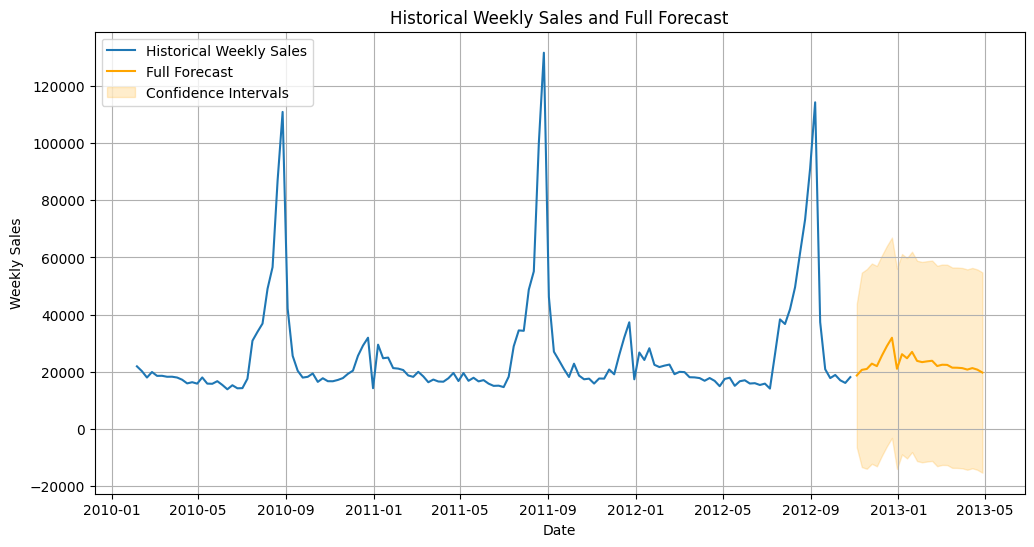

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=2657.734, Time=9.60 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=2721.888, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=2662.891, Time=1.10 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=2664.705, Time=1.14 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=2719.892, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[52] intercept   : AIC=2665.384, Time=4.34 sec
 ARIMA(2,1,2)(1,0,0)[52] intercept   : AIC=2659.704, Time=3.22 sec
 ARIMA(2,1,2)(2,0,1)[52] intercept   : AIC=2661.545, Time=25.07 sec
 ARIMA(2,1,2)(1,0,2)[52] intercept   : AIC=2661.636, Time=18.19 sec
 ARIMA(2,1,2)(0,0,0)[52] intercept   : AIC=2686.963, Time=0.16 sec
 ARIMA(2,1,2)(0,0,2)[52] intercept   : AIC=2659.711, Time=11.78 sec
 ARIMA(2,1,2)(2,0,0)[52] intercept   : AIC=2659.826, Time=15.84 sec
 ARIMA(2,1,2)(2,0,2)[52] intercept   : AIC=inf, Time=45.86 sec
 ARIMA(1,1,2)(1,0,1)[52] intercept   : AIC=2660.379, Time=4.10 sec
 ARIMA(2,1,1)(1,0,1

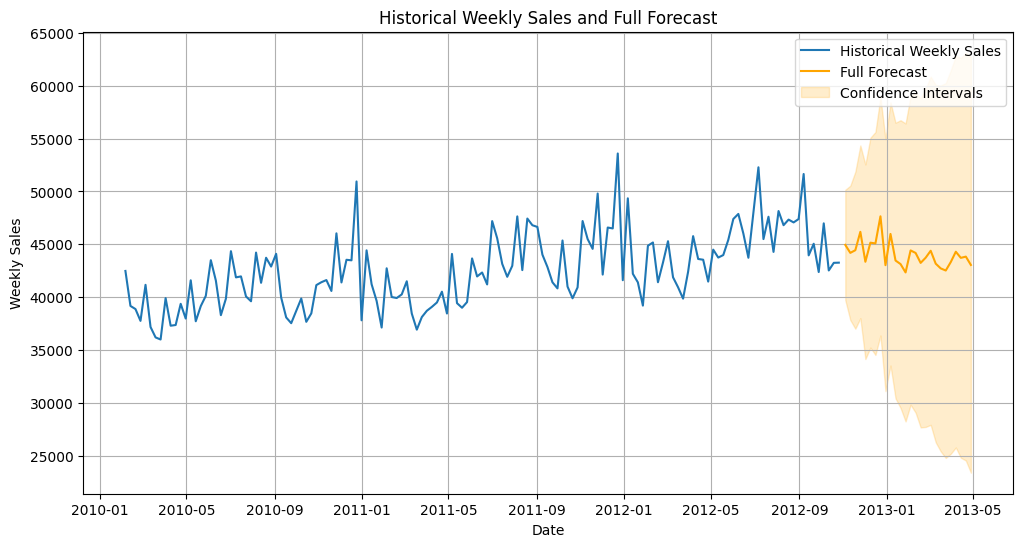

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=3286.712, Time=5.93 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=3364.778, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=3296.510, Time=1.05 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=3317.097, Time=0.81 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=3575.342, Time=0.03 sec
 ARIMA(2,0,2)(0,0,1)[52] intercept   : AIC=3292.581, Time=5.36 sec
 ARIMA(2,0,2)(1,0,0)[52] intercept   : AIC=3284.712, Time=4.58 sec
 ARIMA(2,0,2)(0,0,0)[52] intercept   : AIC=3318.552, Time=0.23 sec
 ARIMA(2,0,2)(2,0,0)[52] intercept   : AIC=3286.711, Time=25.36 sec
 ARIMA(2,0,2)(2,0,1)[52] intercept   : AIC=3288.710, Time=28.26 sec
 ARIMA(1,0,2)(1,0,0)[52] intercept   : AIC=3285.322, Time=2.21 sec
 ARIMA(2,0,1)(1,0,0)[52] intercept   : AIC=3285.398, Time=4.89 sec
 ARIMA(3,0,2)(1,0,0)[52] intercept   : AIC=3286.354, Time=6.45 sec
 ARIMA(2,0,3)(1,0,0)[52] intercept   : AIC=3286.906, Time=4.05 sec
 ARIMA(1,0,1)(1,0

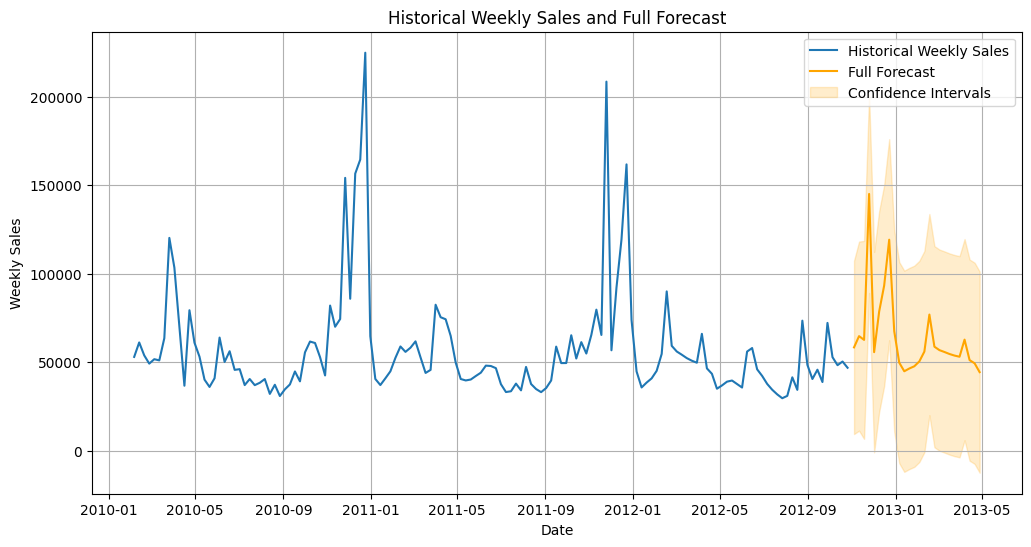

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=8.81 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=2906.709, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=inf, Time=3.56 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=inf, Time=4.06 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=2904.713, Time=0.03 sec
 ARIMA(0,1,0)(1,0,0)[52] intercept   : AIC=inf, Time=1.82 sec
 ARIMA(0,1,0)(0,0,1)[52] intercept   : AIC=2873.356, Time=1.11 sec
 ARIMA(0,1,0)(1,0,1)[52] intercept   : AIC=2865.533, Time=1.17 sec
 ARIMA(0,1,0)(2,0,1)[52] intercept   : AIC=inf, Time=32.94 sec
 ARIMA(0,1,0)(1,0,2)[52] intercept   : AIC=2867.533, Time=6.79 sec
 ARIMA(0,1,0)(0,0,2)[52] intercept   : AIC=inf, Time=23.75 sec
 ARIMA(0,1,0)(2,0,0)[52] intercept   : AIC=inf, Time=18.12 sec
 ARIMA(0,1,0)(2,0,2)[52] intercept   : AIC=2869.533, Time=7.63 sec
 ARIMA(1,1,0)(1,0,1)[52] intercept   : AIC=2786.282, Time=5.49 sec
 ARIMA(1,1,0)(0,0,1)[52] intercept   : AIC=2845.385

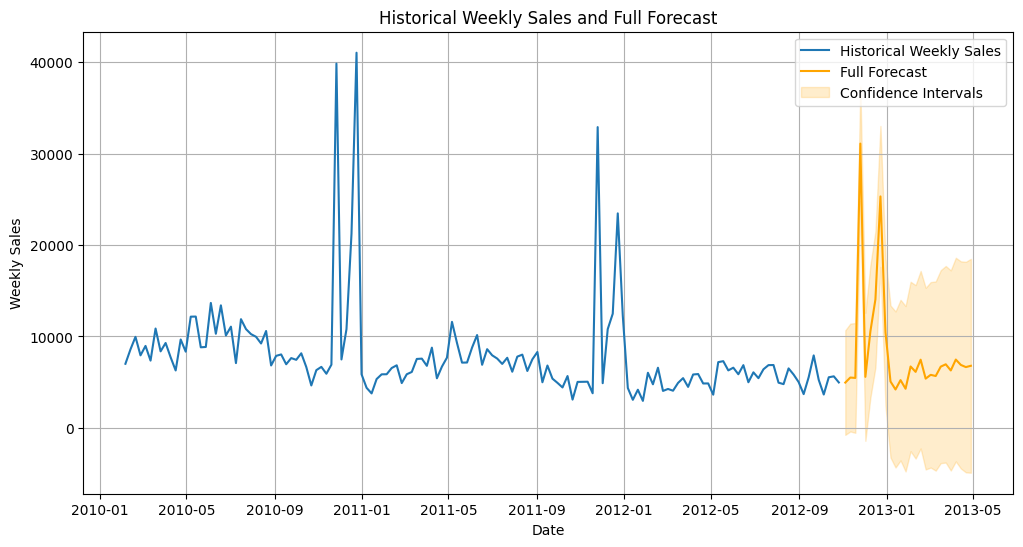

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=3245.770, Time=5.73 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=3294.562, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=3249.641, Time=0.97 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=3244.433, Time=0.68 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=3430.544, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[52] intercept   : AIC=3249.066, Time=0.05 sec
 ARIMA(0,0,1)(1,0,1)[52] intercept   : AIC=3244.933, Time=0.92 sec
 ARIMA(0,0,1)(0,0,2)[52] intercept   : AIC=3244.806, Time=3.26 sec
 ARIMA(0,0,1)(1,0,0)[52] intercept   : AIC=3244.203, Time=0.78 sec
 ARIMA(0,0,1)(2,0,0)[52] intercept   : AIC=3246.104, Time=6.44 sec
 ARIMA(0,0,1)(2,0,1)[52] intercept   : AIC=3245.757, Time=6.48 sec
 ARIMA(0,0,0)(1,0,0)[52] intercept   : AIC=3293.464, Time=0.49 sec
 ARIMA(1,0,1)(1,0,0)[52] intercept   : AIC=3240.750, Time=1.08 sec
 ARIMA(1,0,1)(0,0,0)[52] intercept   : AIC=3247.100, Time=0.07 sec
 ARIMA(1,0,1)(2,0,0

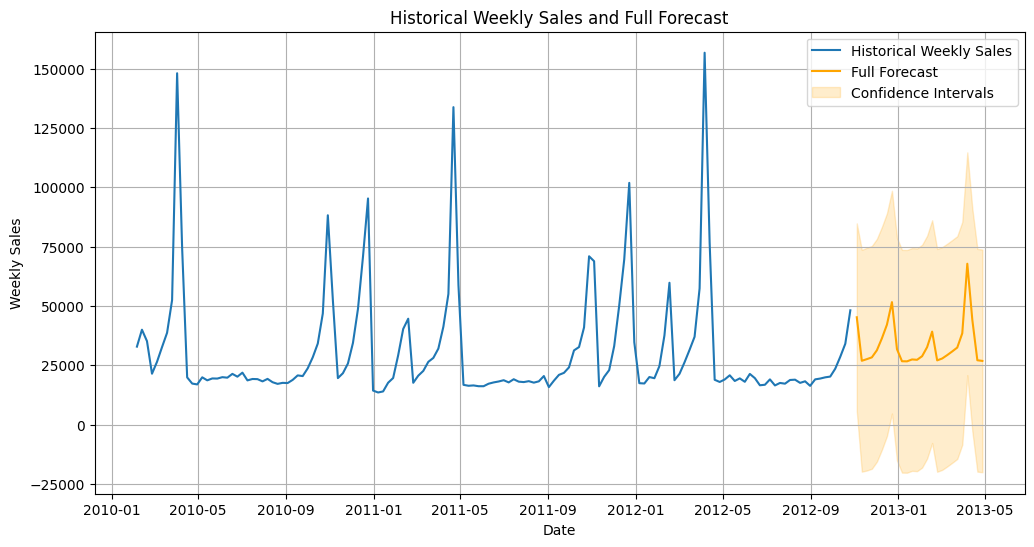

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=2937.461, Time=5.76 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=3021.730, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=2935.977, Time=0.77 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=2945.623, Time=1.93 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=3019.784, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=2968.823, Time=0.06 sec
 ARIMA(1,1,0)(2,0,0)[52] intercept   : AIC=2937.234, Time=4.36 sec
 ARIMA(1,1,0)(1,0,1)[52] intercept   : AIC=2937.240, Time=1.71 sec
 ARIMA(1,1,0)(0,0,1)[52] intercept   : AIC=2942.639, Time=1.06 sec
 ARIMA(1,1,0)(2,0,1)[52] intercept   : AIC=2939.232, Time=12.70 sec
 ARIMA(0,1,0)(1,0,0)[52] intercept   : AIC=2995.177, Time=0.63 sec
 ARIMA(2,1,0)(1,0,0)[52] intercept   : AIC=2936.172, Time=1.13 sec
 ARIMA(1,1,1)(1,0,0)[52] intercept   : AIC=2934.965, Time=1.27 sec
 ARIMA(1,1,1)(0,0,0)[52] intercept   : AIC=2970.444, Time=0.09 sec
 ARIMA(1,1,1)(2,0,

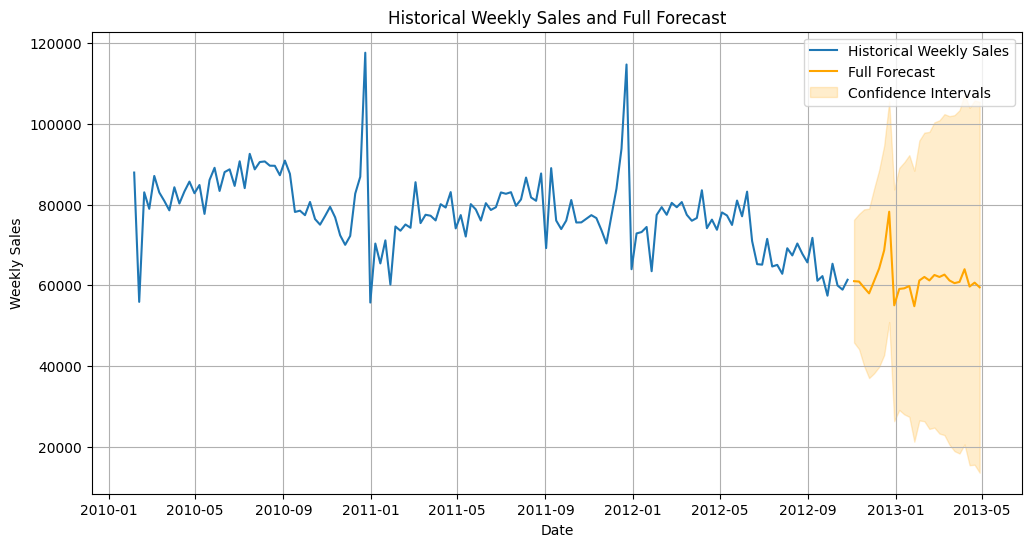

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=inf, Time=10.99 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=3156.152, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=2942.714, Time=1.23 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=3058.627, Time=0.87 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=3297.285, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=2995.783, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[52] intercept   : AIC=2944.332, Time=4.57 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=2943.019, Time=1.68 sec
 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=inf, Time=4.09 sec
 ARIMA(1,0,0)(2,0,1)[52] intercept   : AIC=inf, Time=44.80 sec
 ARIMA(0,0,0)(1,0,0)[52] intercept   : AIC=inf, Time=3.80 sec
 ARIMA(2,0,0)(1,0,0)[52] intercept   : AIC=2945.011, Time=1.96 sec
 ARIMA(1,0,1)(1,0,0)[52] intercept   : AIC=2943.260, Time=2.91 sec
 ARIMA(0,0,1)(1,0,0)[52] intercept   : AIC=3020.805, Time=4.53 sec
 ARIMA(2,0,1)(1,0,0)[52] intercept   

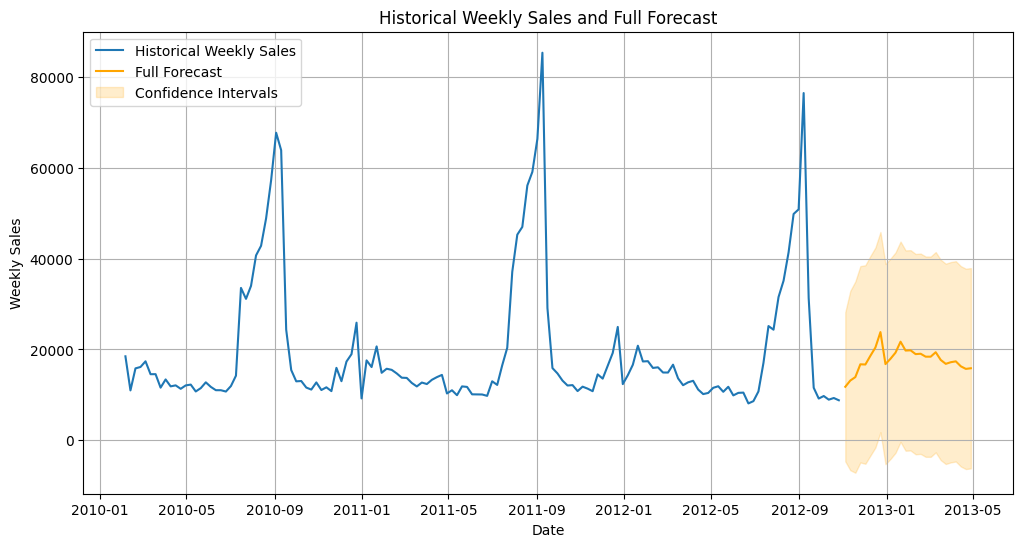

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=2784.884, Time=5.68 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=2885.791, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=2786.866, Time=0.77 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=2792.501, Time=1.03 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=2883.898, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[52] intercept   : AIC=2786.940, Time=5.14 sec
 ARIMA(2,1,2)(1,0,0)[52] intercept   : AIC=2784.536, Time=4.42 sec
 ARIMA(2,1,2)(0,0,0)[52] intercept   : AIC=2796.857, Time=0.22 sec
 ARIMA(2,1,2)(2,0,0)[52] intercept   : AIC=2784.019, Time=16.76 sec
 ARIMA(2,1,2)(3,0,0)[52] intercept   : AIC=2786.006, Time=62.21 sec
 ARIMA(2,1,2)(2,0,1)[52] intercept   : AIC=2785.829, Time=32.22 sec
 ARIMA(2,1,2)(3,0,1)[52] intercept   : AIC=inf, Time=121.24 sec
 ARIMA(1,1,2)(2,0,0)[52] intercept   : AIC=2782.448, Time=11.99 sec
 ARIMA(1,1,2)(1,0,0)[52] intercept   : AIC=2782.862, Time=2.14 sec
 ARIMA(1,1,2)(3,0,

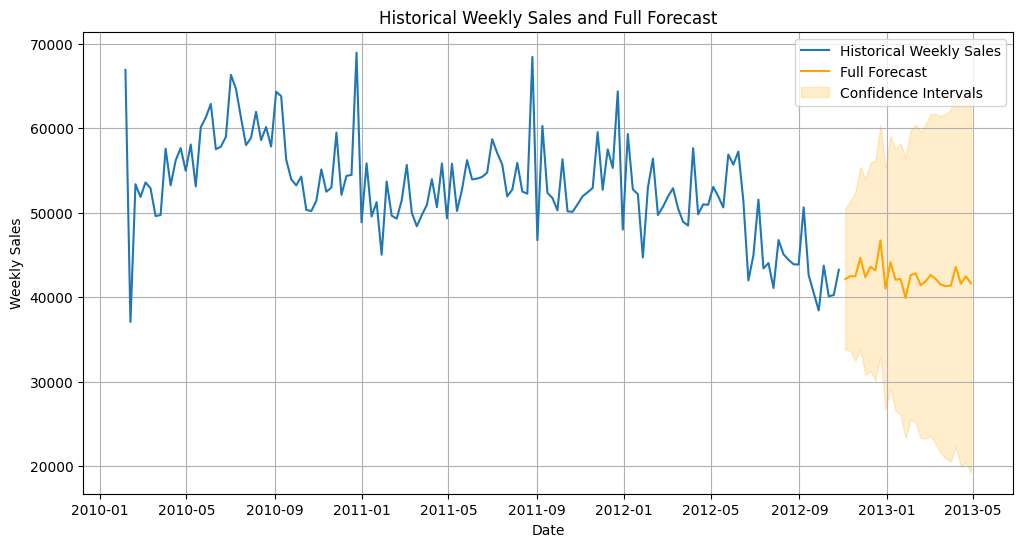

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=3152.763, Time=5.14 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=3262.289, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=3162.122, Time=0.98 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=3200.619, Time=0.76 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=3436.693, Time=0.03 sec
 ARIMA(2,0,2)(0,0,1)[52] intercept   : AIC=3160.733, Time=3.45 sec
 ARIMA(2,0,2)(1,0,0)[52] intercept   : AIC=3150.933, Time=5.60 sec
 ARIMA(2,0,2)(0,0,0)[52] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(2,0,2)(2,0,0)[52] intercept   : AIC=3152.876, Time=18.92 sec
 ARIMA(2,0,2)(2,0,1)[52] intercept   : AIC=inf, Time=41.56 sec
 ARIMA(1,0,2)(1,0,0)[52] intercept   : AIC=3157.113, Time=2.82 sec
 ARIMA(2,0,1)(1,0,0)[52] intercept   : AIC=3151.458, Time=3.40 sec
 ARIMA(3,0,2)(1,0,0)[52] intercept   : AIC=3149.870, Time=5.85 sec
 ARIMA(3,0,2)(0,0,0)[52] intercept   : AIC=3198.316, Time=0.18 sec
 ARIMA(3,0,2)(2,0,0)[52] in

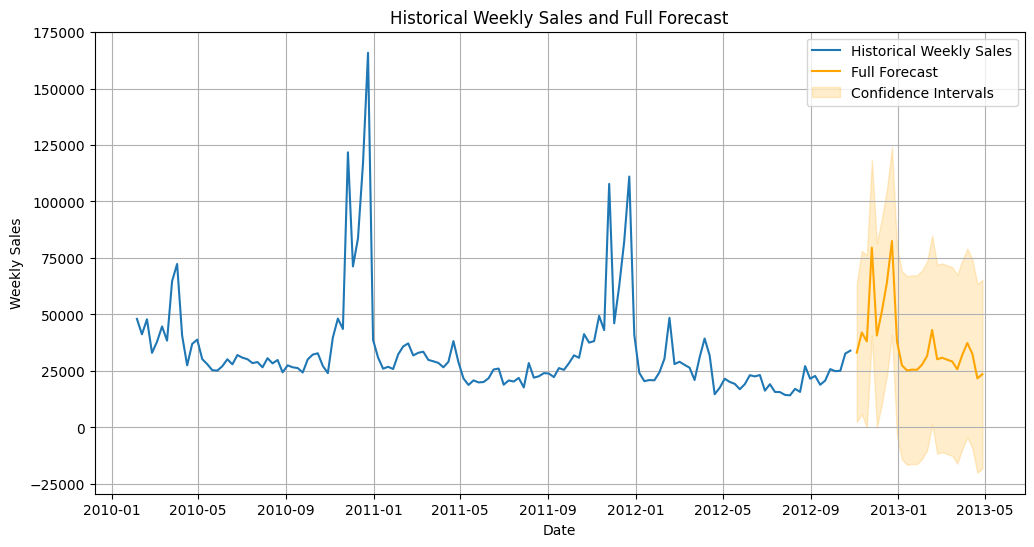

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=12.01 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=2859.920, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=inf, Time=3.37 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=inf, Time=5.90 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=2857.928, Time=0.04 sec
 ARIMA(0,1,0)(1,0,0)[52] intercept   : AIC=inf, Time=1.86 sec
 ARIMA(0,1,0)(0,0,1)[52] intercept   : AIC=inf, Time=3.76 sec
 ARIMA(0,1,0)(1,0,1)[52] intercept   : AIC=inf, Time=6.29 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=2840.766, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[52] intercept   : AIC=inf, Time=4.30 sec
 ARIMA(1,1,0)(1,0,1)[52] intercept   : AIC=inf, Time=7.80 sec
 ARIMA(2,1,0)(0,0,0)[52] intercept   : AIC=2825.031, Time=0.06 sec
 ARIMA(2,1,0)(1,0,0)[52] intercept   : AIC=inf, Time=3.53 sec
 ARIMA(2,1,0)(0,0,1)[52] intercept   : AIC=2796.763, Time=1.07 sec
 ARIMA(2,1,0)(1,0,1)[52] intercept   : AIC=2762.593, Time=8.45 

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=2934.021, Time=4.92 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=2986.793, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=2943.910, Time=0.95 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=2933.050, Time=0.94 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=3177.920, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[52] intercept   : AIC=2941.340, Time=0.05 sec
 ARIMA(0,0,1)(1,0,1)[52] intercept   : AIC=2933.777, Time=1.10 sec
 ARIMA(0,0,1)(0,0,2)[52] intercept   : AIC=2932.320, Time=3.62 sec
 ARIMA(0,0,1)(1,0,2)[52] intercept   : AIC=2933.496, Time=7.13 sec
 ARIMA(0,0,1)(0,0,3)[52] intercept   : AIC=2933.885, Time=13.46 sec
 ARIMA(0,0,1)(1,0,3)[52] intercept   : AIC=2935.179, Time=17.28 sec
 ARIMA(0,0,0)(0,0,2)[52] intercept   : AIC=inf, Time=4.32 sec
 ARIMA(1,0,1)(0,0,2)[52] intercept   : AIC=2933.610, Time=6.17 sec
 ARIMA(0,0,2)(0,0,2)[52] intercept   : AIC=2931.793, Time=4.38 sec
 ARIMA(0,0,2)(0,0,1)[5

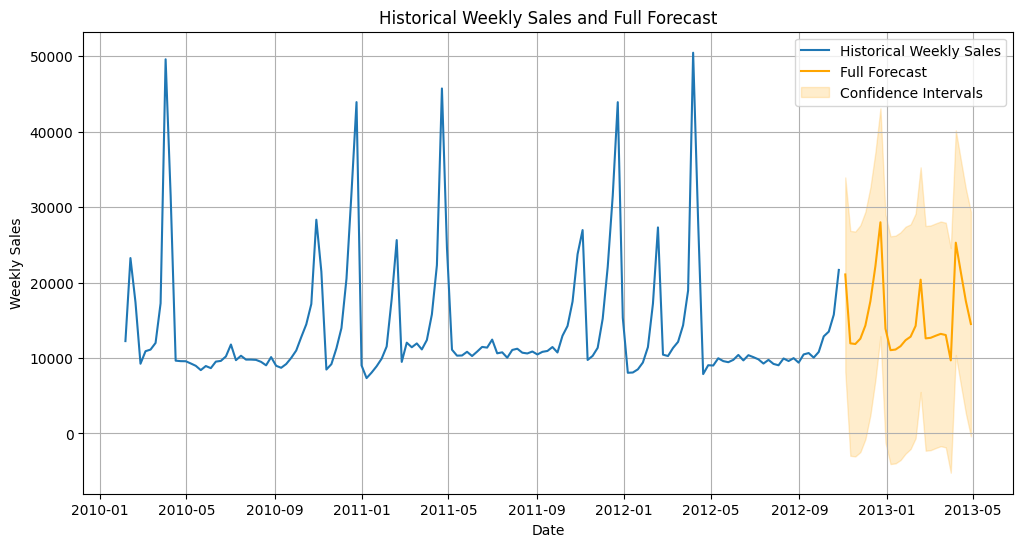

Performing stepwise search to minimize aic


In [ ]:
for i in range(1, 4):
    for j in range(1, 7):
        forecast_sales(df, 'Store', i, 'Dept', j)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=2934.021, Time=13.30 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=2986.793, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=2943.910, Time=2.44 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=2933.050, Time=3.41 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=3177.920, Time=0.19 sec
 ARIMA(0,0,1)(0,0,0)[52] intercept   : AIC=2941.340, Time=0.34 sec
 ARIMA(0,0,1)(1,0,1)[52] intercept   : AIC=2933.777, Time=3.01 sec
 ARIMA(0,0,1)(0,0,2)[52] intercept   : AIC=2932.320, Time=6.15 sec
 ARIMA(0,0,1)(1,0,2)[52] intercept   : AIC=2933.496, Time=8.31 sec
 ARIMA(0,0,1)(0,0,3)[52] intercept   : AIC=2933.885, Time=15.28 sec
 ARIMA(0,0,1)(1,0,3)[52] intercept   : AIC=2935.179, Time=19.93 sec
 ARIMA(0,0,0)(0,0,2)[52] intercept   : AIC=inf, Time=6.19 sec
 ARIMA(1,0,1)(0,0,2)[52] intercept   : AIC=2933.610, Time=5.96 sec
 ARIMA(0,0,2)(0,0,2)[52] intercept   : AIC=2931.793, Time=7.31 sec
 ARIMA(0,0,2)(0,0,1)[

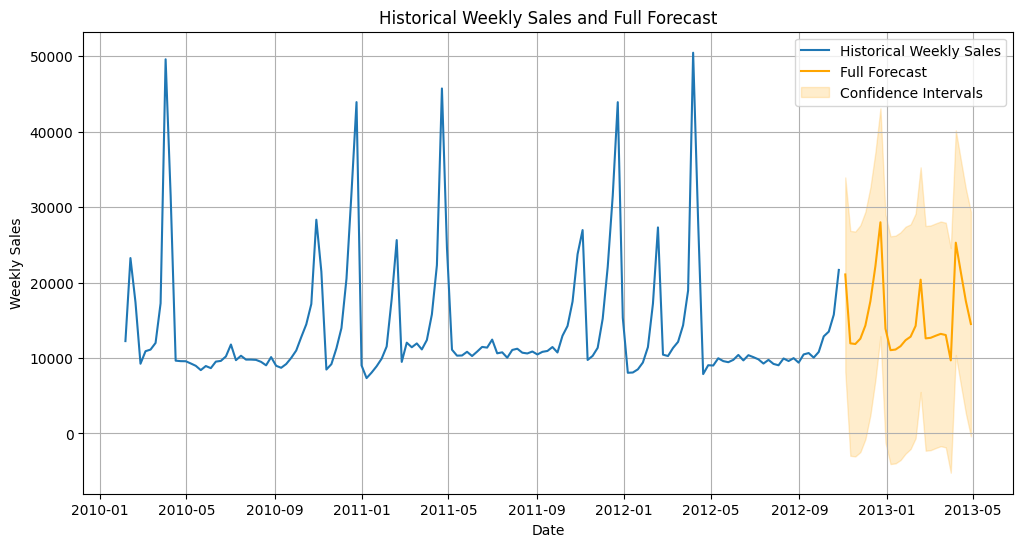

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=2675.514, Time=13.67 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=2737.574, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=2689.272, Time=2.64 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=inf, Time=5.37 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=3321.123, Time=0.06 sec
 ARIMA(2,0,2)(0,0,1)[52] intercept   : AIC=2682.158, Time=6.96 sec
 ARIMA(2,0,2)(1,0,0)[52] intercept   : AIC=2674.013, Time=10.53 sec
 ARIMA(2,0,2)(0,0,0)[52] intercept   : AIC=2714.883, Time=0.42 sec
 ARIMA(2,0,2)(2,0,0)[52] intercept   : AIC=2676.013, Time=46.41 sec
 ARIMA(2,0,2)(2,0,1)[52] intercept   : AIC=inf, Time=50.27 sec
 ARIMA(1,0,2)(1,0,0)[52] intercept   : AIC=2674.920, Time=5.73 sec
 ARIMA(2,0,1)(1,0,0)[52] intercept   : AIC=inf, Time=9.11 sec
 ARIMA(3,0,2)(1,0,0)[52] intercept   : AIC=2674.726, Time=12.22 sec
 ARIMA(2,0,3)(1,0,0)[52] intercept   : AIC=2675.485, Time=10.24 sec
 ARIMA(1,0,1)(1,0,0)[52] int

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=inf, Time=13.40 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=2948.414, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=inf, Time=7.90 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=inf, Time=4.07 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=3109.985, Time=0.03 sec
 ARIMA(0,0,0)(1,0,0)[52] intercept   : AIC=2931.943, Time=0.70 sec
 ARIMA(0,0,0)(2,0,0)[52] intercept   : AIC=2924.154, Time=6.96 sec
 ARIMA(0,0,0)(3,0,0)[52] intercept   : AIC=inf, Time=20.50 sec
 ARIMA(0,0,0)(2,0,1)[52] intercept   : AIC=inf, Time=27.00 sec
 ARIMA(0,0,0)(1,0,1)[52] intercept   : AIC=2901.144, Time=1.22 sec
 ARIMA(0,0,0)(0,0,1)[52] intercept   : AIC=inf, Time=2.54 sec
 ARIMA(0,0,0)(1,0,2)[52] intercept   : AIC=2890.158, Time=6.01 sec
 ARIMA(0,0,0)(0,0,2)[52] intercept   : AIC=2888.629, Time=4.71 sec
 ARIMA(0,0,0)(0,0,3)[52] intercept   : AIC=inf, Time=15.38 sec
 ARIMA(0,0,0)(1,0,3)[52] intercept   : AIC=inf, Ti

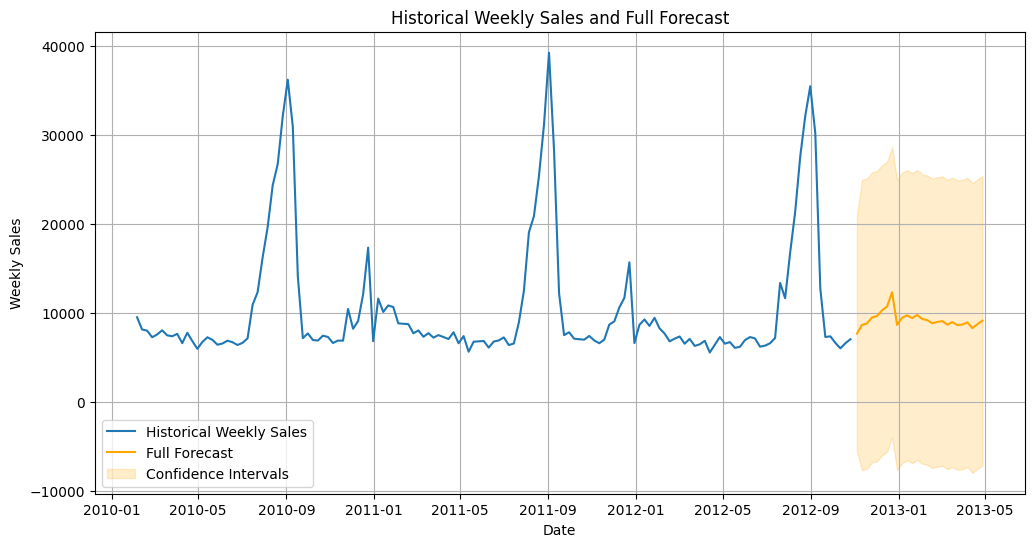

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=2346.766, Time=10.46 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=2468.721, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=2353.955, Time=7.16 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=inf, Time=4.51 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=3120.300, Time=0.03 sec
 ARIMA(2,0,2)(0,0,1)[52] intercept   : AIC=inf, Time=10.38 sec
 ARIMA(2,0,2)(1,0,0)[52] intercept   : AIC=2350.338, Time=12.77 sec
 ARIMA(2,0,2)(2,0,1)[52] intercept   : AIC=inf, Time=46.05 sec
 ARIMA(2,0,2)(1,0,2)[52] intercept   : AIC=2350.071, Time=49.83 sec
 ARIMA(2,0,2)(0,0,0)[52] intercept   : AIC=2371.946, Time=0.15 sec
 ARIMA(2,0,2)(0,0,2)[52] intercept   : AIC=inf, Time=37.19 sec
 ARIMA(2,0,2)(2,0,0)[52] intercept   : AIC=2351.790, Time=48.43 sec
 ARIMA(2,0,2)(2,0,2)[52] intercept   : AIC=inf, Time=54.19 sec
 ARIMA(1,0,2)(1,0,1)[52] intercept   : AIC=2343.735, Time=10.14 sec
 ARIMA(1,0,2)(0,0,1)[52] intercept 

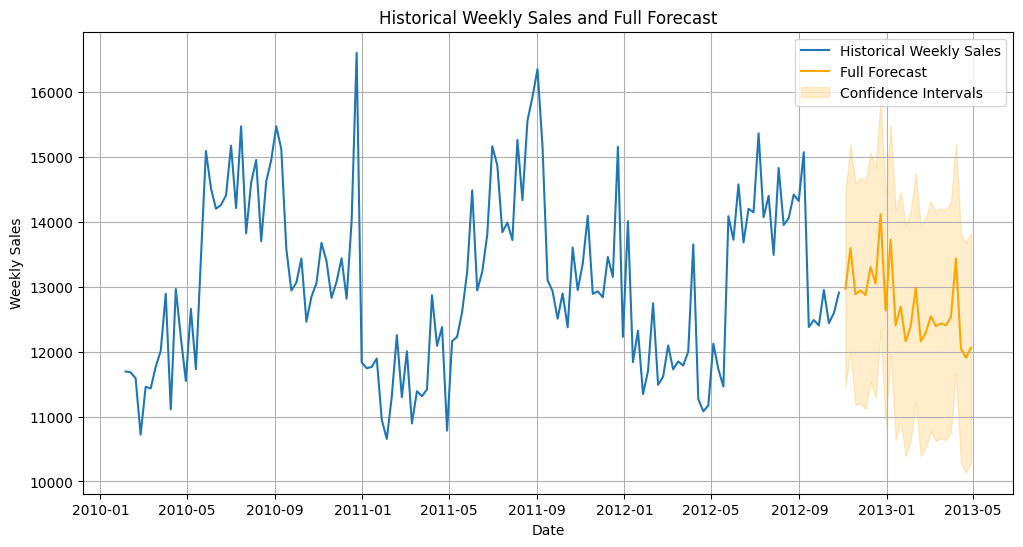

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=3012.936, Time=5.75 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=3095.326, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=3023.433, Time=1.65 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=3042.780, Time=0.92 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=3245.245, Time=0.03 sec
 ARIMA(2,0,2)(0,0,1)[52] intercept   : AIC=3020.255, Time=3.06 sec
 ARIMA(2,0,2)(1,0,0)[52] intercept   : AIC=inf, Time=10.09 sec
 ARIMA(2,0,2)(2,0,1)[52] intercept   : AIC=inf, Time=36.74 sec
 ARIMA(2,0,2)(1,0,2)[52] intercept   : AIC=3014.749, Time=22.56 sec
 ARIMA(2,0,2)(0,0,0)[52] intercept   : AIC=3054.735, Time=0.17 sec
 ARIMA(2,0,2)(0,0,2)[52] intercept   : AIC=3015.482, Time=20.56 sec
 ARIMA(2,0,2)(2,0,0)[52] intercept   : AIC=3013.104, Time=20.43 sec
 ARIMA(2,0,2)(2,0,2)[52] intercept   : AIC=inf, Time=53.81 sec
 ARIMA(1,0,2)(1,0,1)[52] intercept   : AIC=3014.640, Time=3.72 sec
 ARIMA(2,0,1)(1,0,1)[52] int

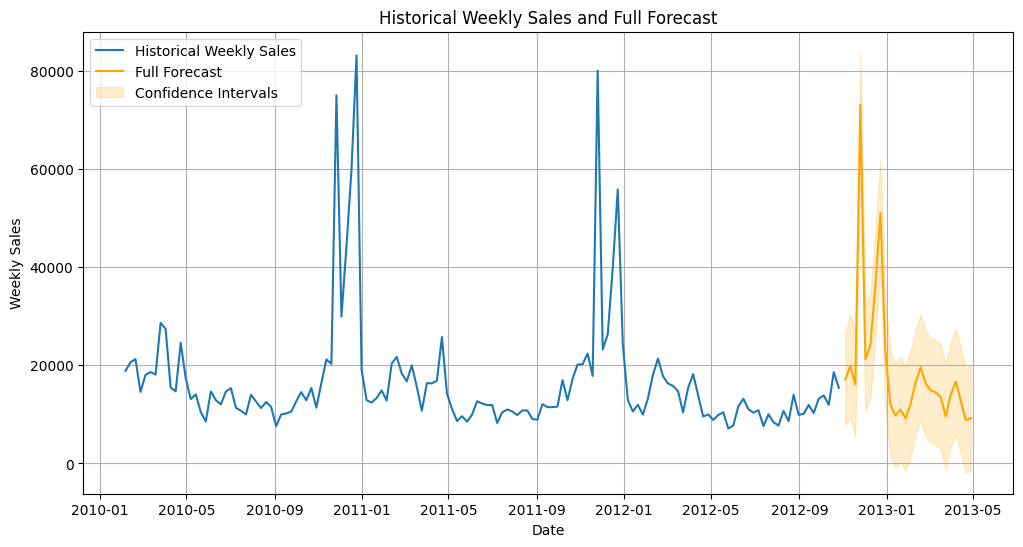

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=12.96 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=2771.603, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=inf, Time=3.18 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=inf, Time=6.12 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=2769.611, Time=0.03 sec
 ARIMA(0,1,0)(1,0,0)[52] intercept   : AIC=inf, Time=2.26 sec
 ARIMA(0,1,0)(0,0,1)[52] intercept   : AIC=inf, Time=3.74 sec
 ARIMA(0,1,0)(1,0,1)[52] intercept   : AIC=inf, Time=7.26 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=2742.558, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[52] intercept   : AIC=inf, Time=4.38 sec
 ARIMA(1,1,0)(1,0,1)[52] intercept   : AIC=inf, Time=8.04 sec
 ARIMA(2,1,0)(0,0,0)[52] intercept   : AIC=2730.431, Time=0.06 sec
 ARIMA(2,1,0)(1,0,0)[52] intercept   : AIC=inf, Time=4.35 sec
 ARIMA(2,1,0)(0,0,1)[52] intercept   : AIC=inf, Time=5.39 sec
 ARIMA(2,1,0)(1,0,1)[52] intercept   : AIC=2646.538, Time=10.17 sec


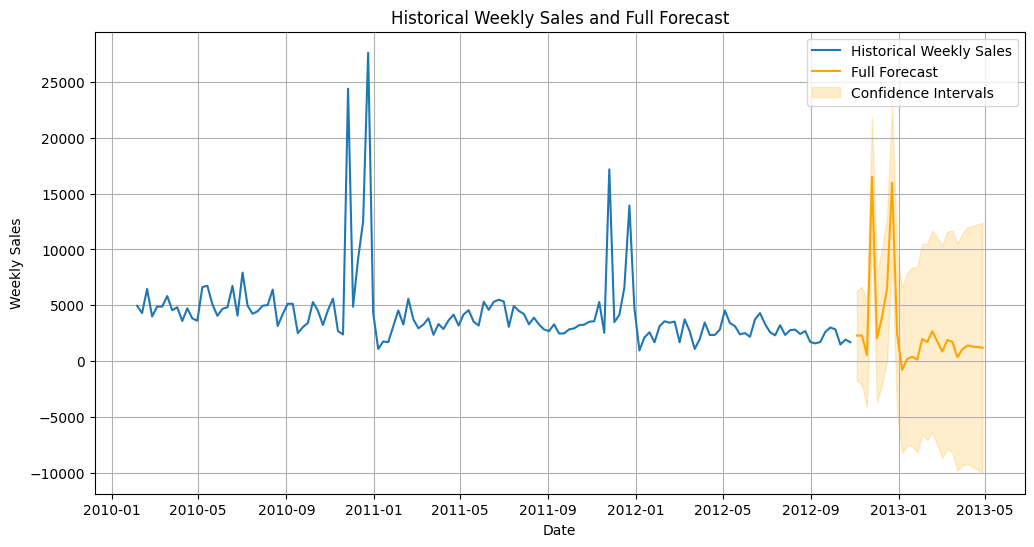

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=2661.677, Time=4.70 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=2733.162, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=2672.130, Time=1.50 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=inf, Time=5.45 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=3090.351, Time=0.06 sec
 ARIMA(2,0,2)(0,0,1)[52] intercept   : AIC=2662.953, Time=2.52 sec
 ARIMA(2,0,2)(1,0,0)[52] intercept   : AIC=2646.486, Time=7.37 sec
 ARIMA(2,0,2)(0,0,0)[52] intercept   : AIC=2687.453, Time=0.15 sec
 ARIMA(2,0,2)(2,0,0)[52] intercept   : AIC=2661.703, Time=20.38 sec
 ARIMA(2,0,2)(2,0,1)[52] intercept   : AIC=2663.652, Time=21.06 sec
 ARIMA(1,0,2)(1,0,0)[52] intercept   : AIC=2649.018, Time=8.38 sec
 ARIMA(2,0,1)(1,0,0)[52] intercept   : AIC=2662.503, Time=3.78 sec
 ARIMA(3,0,2)(1,0,0)[52] intercept   : AIC=2656.967, Time=8.38 sec
 ARIMA(2,0,3)(1,0,0)[52] intercept   : AIC=2648.793, Time=7.54 sec
 ARIMA(1,0,1)(1,0,0)[5

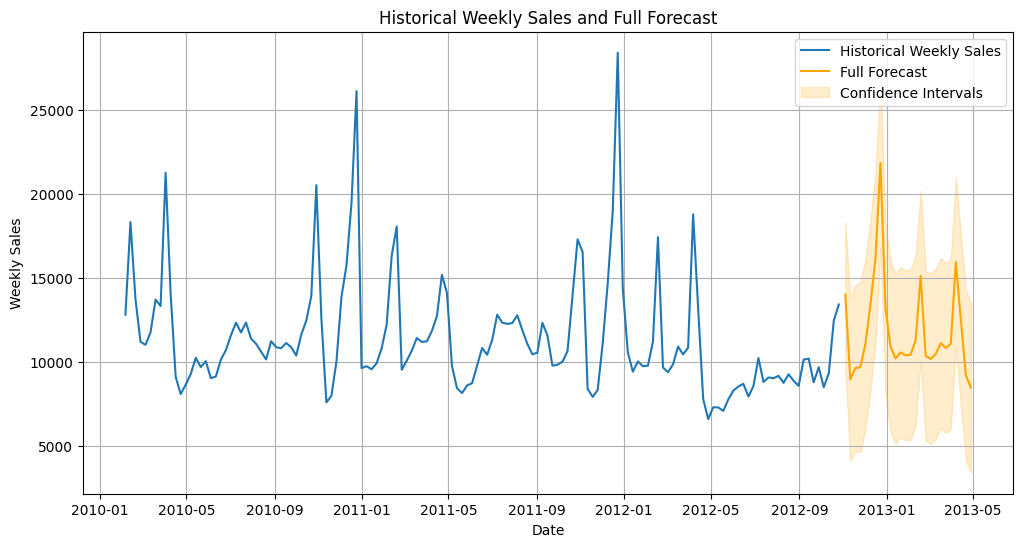

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=2626.427, Time=12.82 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=2746.711, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=2632.401, Time=3.08 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=inf, Time=4.99 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=3290.124, Time=0.06 sec
 ARIMA(2,0,2)(0,0,1)[52] intercept   : AIC=inf, Time=9.50 sec
 ARIMA(2,0,2)(1,0,0)[52] intercept   : AIC=2624.561, Time=10.66 sec
 ARIMA(2,0,2)(0,0,0)[52] intercept   : AIC=2664.766, Time=0.14 sec
 ARIMA(2,0,2)(2,0,0)[52] intercept   : AIC=2626.754, Time=40.66 sec
 ARIMA(2,0,2)(2,0,1)[52] intercept   : AIC=inf, Time=45.80 sec
 ARIMA(1,0,2)(1,0,0)[52] intercept   : AIC=2628.466, Time=12.07 sec
 ARIMA(2,0,1)(1,0,0)[52] intercept   : AIC=2621.304, Time=8.98 sec
 ARIMA(2,0,1)(0,0,0)[52] intercept   : AIC=2663.332, Time=0.11 sec
 ARIMA(2,0,1)(2,0,0)[52] intercept   : AIC=2622.343, Time=37.49 sec
 ARIMA(2,0,1)(1,0,1)[52] int

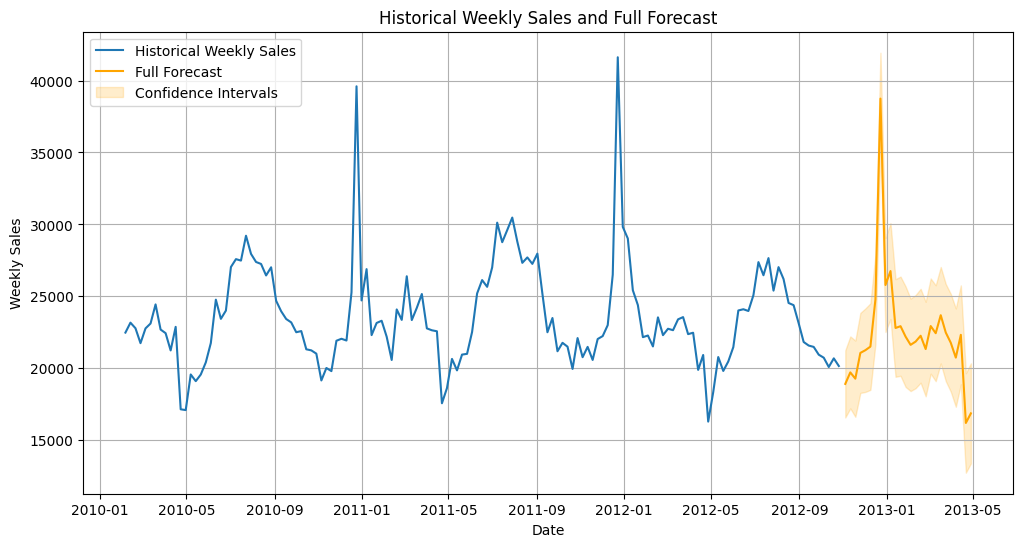

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=inf, Time=11.46 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=2677.665, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=2518.642, Time=3.83 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=inf, Time=4.35 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=2982.594, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=2571.531, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[52] intercept   : AIC=2534.083, Time=8.77 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=inf, Time=6.01 sec
 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=inf, Time=5.22 sec
 ARIMA(1,0,0)(2,0,1)[52] intercept   : AIC=inf, Time=32.25 sec
 ARIMA(0,0,0)(1,0,0)[52] intercept   : AIC=2674.081, Time=0.75 sec
 ARIMA(2,0,0)(1,0,0)[52] intercept   : AIC=2538.586, Time=2.11 sec
 ARIMA(1,0,1)(1,0,0)[52] intercept   : AIC=2516.041, Time=5.28 sec
 ARIMA(1,0,1)(0,0,0)[52] intercept   : AIC=2572.944, Time=0.12 sec
 ARIMA(1,0,1)(2,0,0)[52] intercept   : AIC

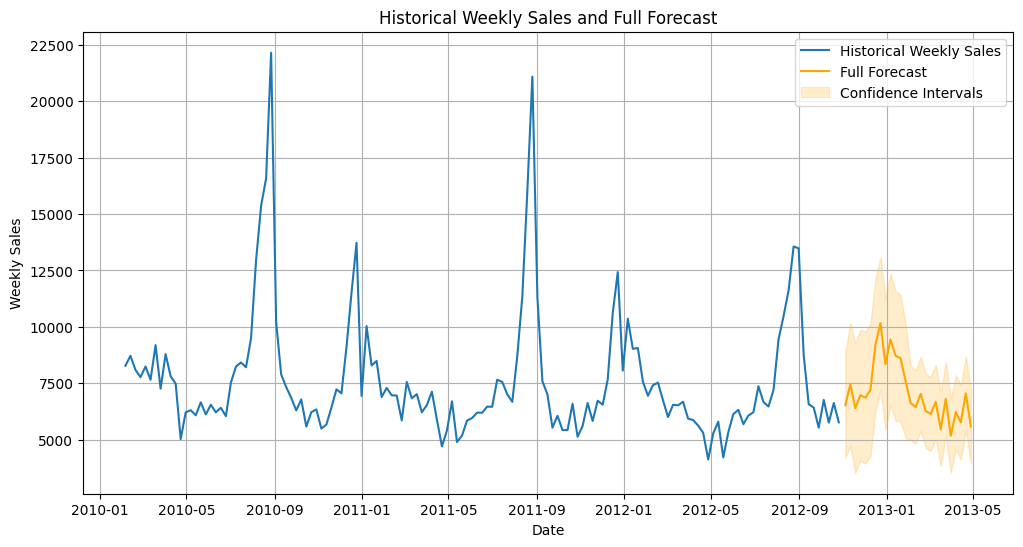

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=2380.339, Time=11.48 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=2574.228, Time=0.08 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=2389.760, Time=2.73 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=inf, Time=4.41 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=3155.533, Time=0.03 sec
 ARIMA(2,0,2)(0,0,1)[52] intercept   : AIC=2386.327, Time=9.75 sec
 ARIMA(2,0,2)(1,0,0)[52] intercept   : AIC=2387.663, Time=11.96 sec
 ARIMA(2,0,2)(2,0,1)[52] intercept   : AIC=inf, Time=48.42 sec
 ARIMA(2,0,2)(1,0,2)[52] intercept   : AIC=2389.151, Time=41.52 sec
 ARIMA(2,0,2)(0,0,0)[52] intercept   : AIC=2410.486, Time=0.28 sec
 ARIMA(2,0,2)(0,0,2)[52] intercept   : AIC=inf, Time=39.01 sec
 ARIMA(2,0,2)(2,0,0)[52] intercept   : AIC=2382.006, Time=41.99 sec
 ARIMA(2,0,2)(2,0,2)[52] intercept   : AIC=inf, Time=51.70 sec
 ARIMA(1,0,2)(1,0,1)[52] intercept   : AIC=2378.916, Time=8.53 sec
 ARIMA(1,0,2)(0,0,1)[52] interce

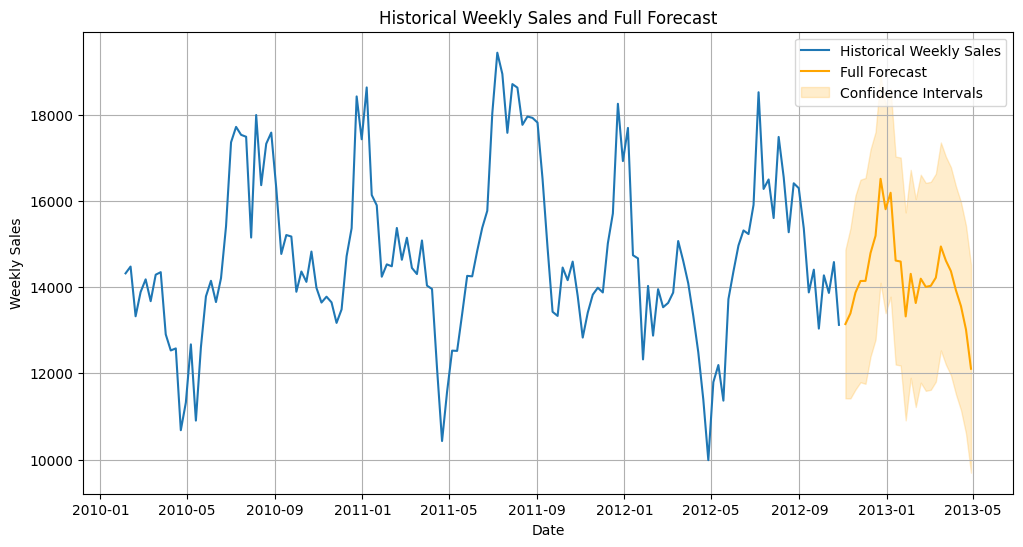

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=inf, Time=11.30 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=2973.240, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=2906.658, Time=2.40 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=inf, Time=4.38 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=3168.990, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=2936.840, Time=0.04 sec
 ARIMA(1,0,0)(2,0,0)[52] intercept   : AIC=inf, Time=24.79 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=2897.287, Time=1.54 sec
 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=2900.738, Time=1.00 sec
 ARIMA(1,0,0)(2,0,1)[52] intercept   : AIC=inf, Time=46.64 sec
 ARIMA(1,0,0)(1,0,2)[52] intercept   : AIC=2895.863, Time=8.42 sec
 ARIMA(1,0,0)(0,0,2)[52] intercept   : AIC=2895.394, Time=4.23 sec
 ARIMA(1,0,0)(0,0,3)[52] intercept   : AIC=2895.104, Time=20.20 sec
 ARIMA(1,0,0)(1,0,3)[52] intercept   : AIC=2896.368, Time=24.53 sec
 ARIMA(0,0,0)(0,0,3)[52] intercept

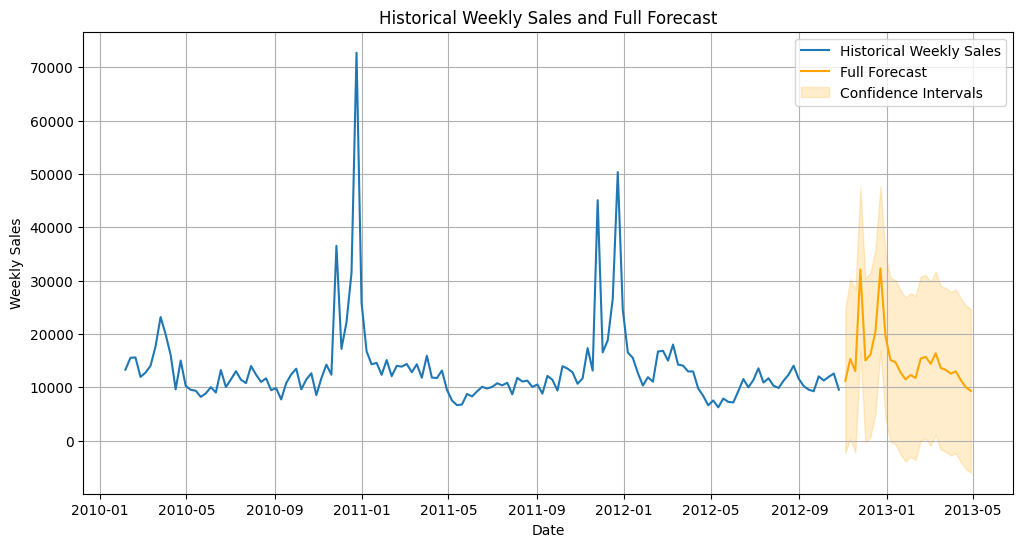

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=inf, Time=12.03 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=2668.371, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=2655.134, Time=1.20 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=inf, Time=5.75 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=2886.497, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=2666.713, Time=0.06 sec
 ARIMA(1,0,0)(2,0,0)[52] intercept   : AIC=2651.629, Time=6.92 sec
 ARIMA(1,0,0)(3,0,0)[52] intercept   : AIC=inf, Time=90.82 sec
 ARIMA(1,0,0)(2,0,1)[52] intercept   : AIC=inf, Time=47.07 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=inf, Time=6.28 sec
 ARIMA(1,0,0)(3,0,1)[52] intercept   : AIC=inf, Time=144.91 sec
 ARIMA(0,0,0)(2,0,0)[52] intercept   : AIC=2656.571, Time=4.39 sec
 ARIMA(2,0,0)(2,0,0)[52] intercept   : AIC=2651.490, Time=11.46 sec
 ARIMA(2,0,0)(1,0,0)[52] intercept   : AIC=2653.082, Time=1.26 sec
 ARIMA(2,0,0)(3,0,0)[52] intercept   : AIC=

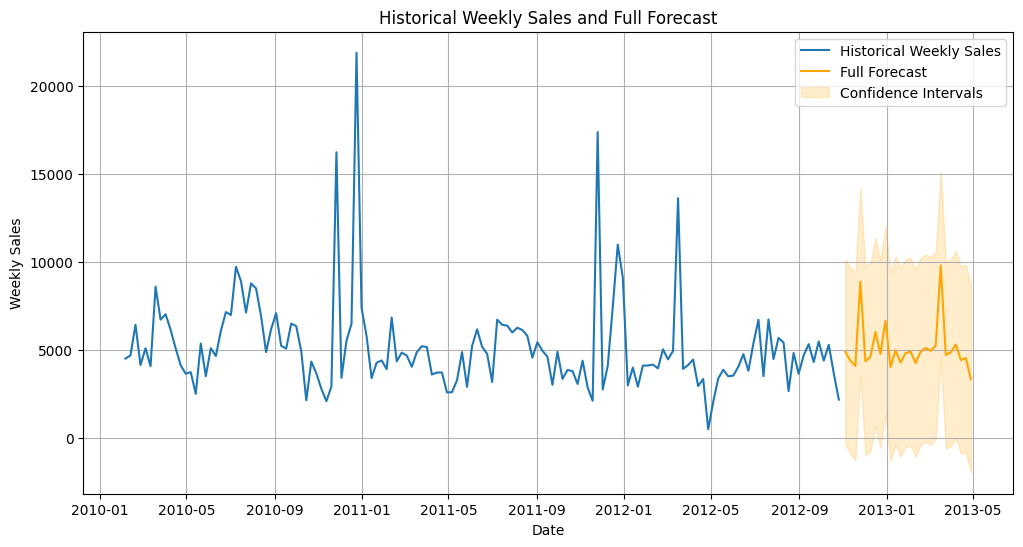

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=3007.558, Time=4.68 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=3062.211, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=3015.495, Time=1.66 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=3007.175, Time=1.13 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=3305.968, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[52] intercept   : AIC=3015.579, Time=0.09 sec
 ARIMA(0,0,1)(1,0,1)[52] intercept   : AIC=3008.298, Time=1.26 sec
 ARIMA(0,0,1)(0,0,2)[52] intercept   : AIC=3006.944, Time=6.10 sec
 ARIMA(0,0,1)(1,0,2)[52] intercept   : AIC=3008.384, Time=5.73 sec
 ARIMA(0,0,1)(0,0,3)[52] intercept   : AIC=3008.599, Time=15.01 sec
 ARIMA(0,0,1)(1,0,3)[52] intercept   : AIC=3010.107, Time=23.72 sec
 ARIMA(0,0,0)(0,0,2)[52] intercept   : AIC=inf, Time=3.49 sec
 ARIMA(1,0,1)(0,0,2)[52] intercept   : AIC=3006.852, Time=7.83 sec
 ARIMA(1,0,1)(0,0,1)[52] intercept   : AIC=3006.825, Time=1.18 sec
 ARIMA(1,0,1)(0,0,0)[5

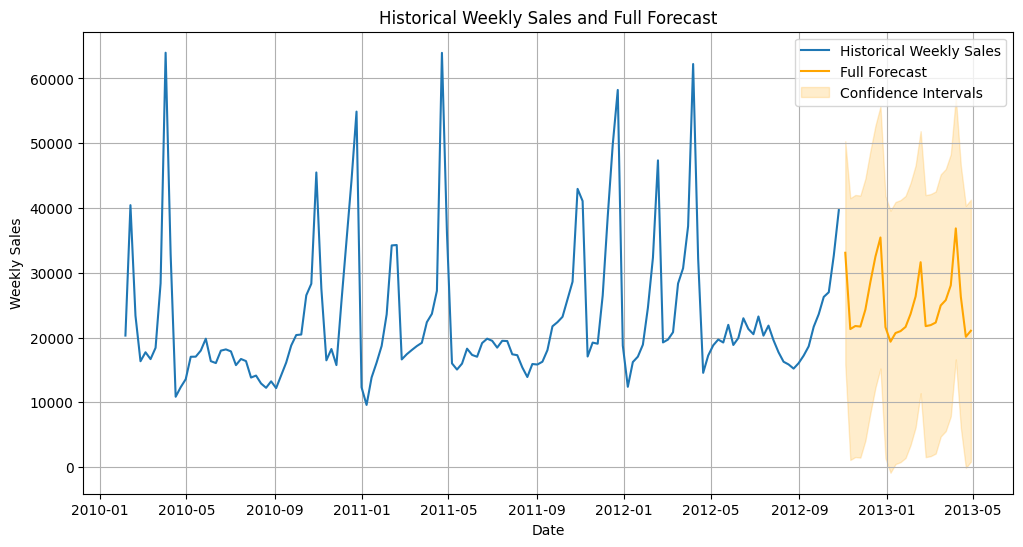

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[52] intercept   : AIC=inf, Time=39.32 sec
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=1719.091, Time=0.26 sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=1721.179, Time=5.51 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=1720.716, Time=3.54 sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=1745.250, Time=0.26 sec
 ARIMA(0,0,0)(1,1,0)[52] intercept   : AIC=1720.918, Time=1.70 sec
 ARIMA(0,0,0)(0,1,1)[52] intercept   : AIC=1720.901, Time=1.76 sec
 ARIMA(0,0,0)(1,1,1)[52] intercept   : AIC=1722.595, Time=16.50 sec
 ARIMA(1,0,0)(0,1,0)[52] intercept   : AIC=1719.189, Time=0.46 sec
 ARIMA(0,0,1)(0,1,0)[52] intercept   : AIC=1718.805, Time=0.80 sec
 ARIMA(0,0,1)(1,1,0)[52] intercept   : AIC=1720.734, Time=4.75 sec
 ARIMA(0,0,1)(1,1,1)[52] intercept   : AIC=inf, Time=15.04 sec
 ARIMA(1,0,1)(0,1,0)[52] intercept   : AIC=1720.284, Time=1.05 sec
 ARIMA(0,0,2)(0,1,0)[52] intercept   : AIC=1720.928, Time=0.86 sec
 ARIMA(1,0,2)(0,1,0)[52] i

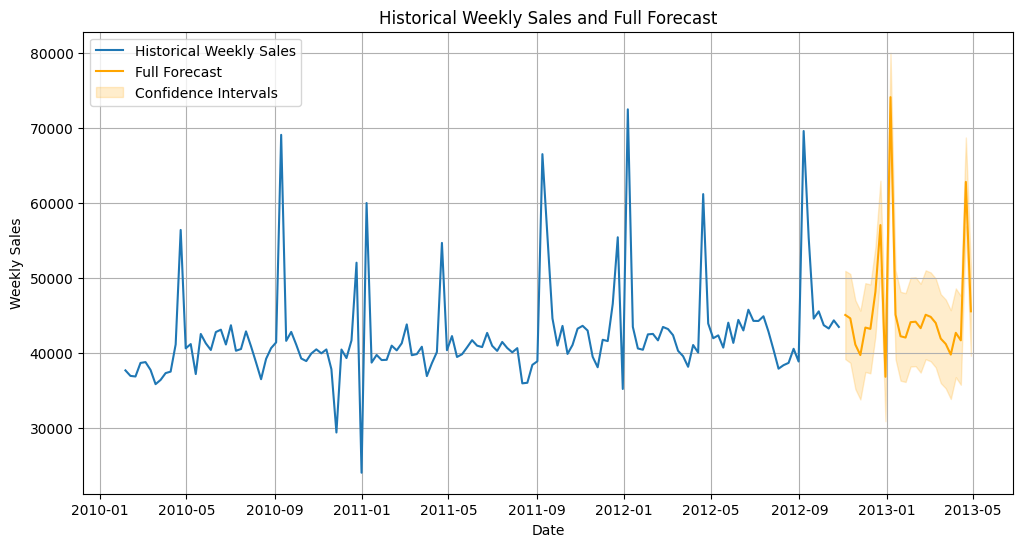

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=inf, Time=11.68 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=3065.691, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=2946.729, Time=1.16 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=2997.195, Time=1.00 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=3268.673, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=2995.210, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[52] intercept   : AIC=2946.947, Time=7.92 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=inf, Time=6.17 sec
 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=2951.373, Time=0.98 sec
 ARIMA(1,0,0)(2,0,1)[52] intercept   : AIC=inf, Time=77.24 sec
 ARIMA(0,0,0)(1,0,0)[52] intercept   : AIC=3054.536, Time=0.66 sec
 ARIMA(2,0,0)(1,0,0)[52] intercept   : AIC=2940.678, Time=1.45 sec
 ARIMA(2,0,0)(0,0,0)[52] intercept   : AIC=2993.094, Time=0.07 sec
 ARIMA(2,0,0)(2,0,0)[52] intercept   : AIC=2941.862, Time=8.88 sec
 ARIMA(2,0,0)(1,0,1)[52] interce

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(3,0,1)(1,0,2)[52]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/pmdarima/arima/arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/pmdarima/arima/arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "/usr/local/lib/python3.10/dist-packages/pmdarima/arima/arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
  File "/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/mlemodel.py", line 703, in fit
    mlefit = super().fit(start_params, method=method,
  File "/usr/local/lib/python3.10/dist-packa

 ARIMA(3,0,1)(1,0,2)[52]             : AIC=inf, Time=nan sec

Best model:  ARIMA(2,0,0)(1,0,2)[52]          
Total fit time: 1001.112 seconds
Forecasted sales for the next period:
            Weekly_Sales_Forecast      Lower_CI      Upper_CI
Date                                                         
2012-11-04           12353.272761   5916.165859  18790.379662
2012-11-11           13031.006356   5356.253838  20705.758873
2012-11-18           12086.694473   2944.085986  21229.302961
2012-11-25           11885.275389   1609.981269  22160.569508
2012-12-02           21813.264540  10478.270678  33148.258403
2012-12-09           18077.097275   5787.115331  30367.079219
2012-12-16           18321.360583   5141.663617  31501.057548
2012-12-23           19398.213644   5387.106140  33409.321148
2012-12-30           11711.939139  -3083.923289  26507.801568
2013-01-06           44414.665510  28874.240203  59955.090817
2013-01-13           23610.018158   7359.492572  39860.543744
2013-01-20    

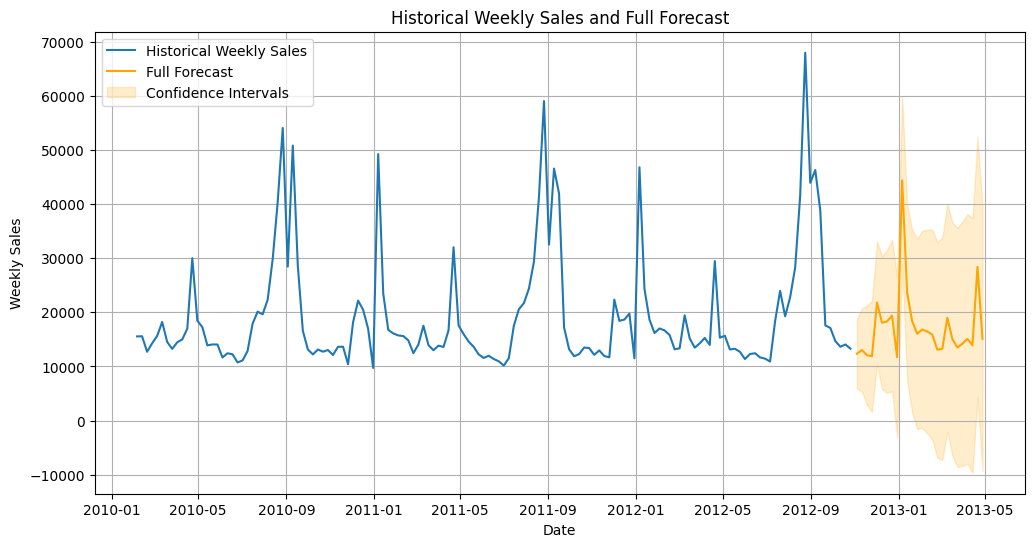

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[52] intercept   : AIC=1622.960, Time=43.05 sec
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=1617.097, Time=0.29 sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=1619.903, Time=4.72 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=1619.658, Time=3.14 sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=1667.747, Time=0.26 sec
 ARIMA(0,0,0)(1,1,0)[52] intercept   : AIC=1617.714, Time=2.10 sec
 ARIMA(0,0,0)(0,1,1)[52] intercept   : AIC=1617.497, Time=1.72 sec
 ARIMA(0,0,0)(1,1,1)[52] intercept   : AIC=1617.672, Time=11.02 sec
 ARIMA(1,0,0)(0,1,0)[52] intercept   : AIC=1619.130, Time=0.31 sec
 ARIMA(0,0,1)(0,1,0)[52] intercept   : AIC=1619.113, Time=0.49 sec
 ARIMA(1,0,1)(0,1,0)[52] intercept   : AIC=1620.961, Time=0.86 sec

Best model:  ARIMA(0,0,0)(0,1,0)[52] intercept
Total fit time: 68.064 seconds
Forecasted sales for the next period:
            Weekly_Sales_Forecast      Lower_CI      Upper_CI
Date                                   

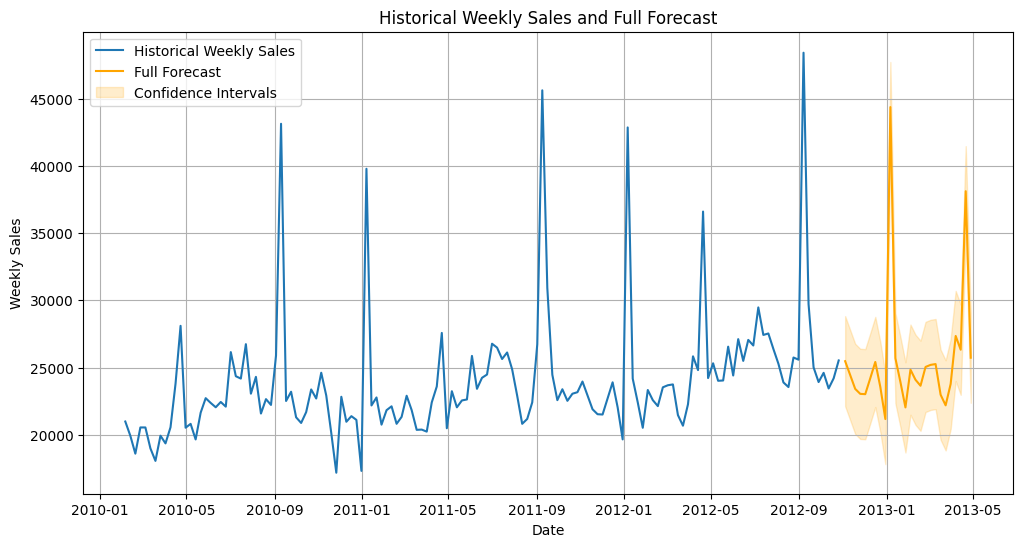

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[52] intercept   : AIC=inf, Time=40.30 sec
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=1924.931, Time=0.17 sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=1927.146, Time=4.73 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=1927.296, Time=3.24 sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=1923.324, Time=0.29 sec
 ARIMA(0,0,0)(1,1,0)[52] intercept   : AIC=1926.848, Time=7.61 sec
 ARIMA(0,0,0)(0,1,1)[52] intercept   : AIC=1926.841, Time=3.62 sec
 ARIMA(0,0,0)(1,1,1)[52] intercept   : AIC=inf, Time=8.77 sec
 ARIMA(1,0,0)(0,1,0)[52] intercept   : AIC=1925.180, Time=0.33 sec
 ARIMA(0,0,1)(0,1,0)[52] intercept   : AIC=1925.299, Time=0.41 sec
 ARIMA(1,0,1)(0,1,0)[52] intercept   : AIC=1927.233, Time=1.17 sec

Best model:  ARIMA(0,0,0)(0,1,0)[52]          
Total fit time: 70.740 seconds
Forecasted sales for the next period:
            Weekly_Sales_Forecast       Lower_CI       Upper_CI
Date                                            

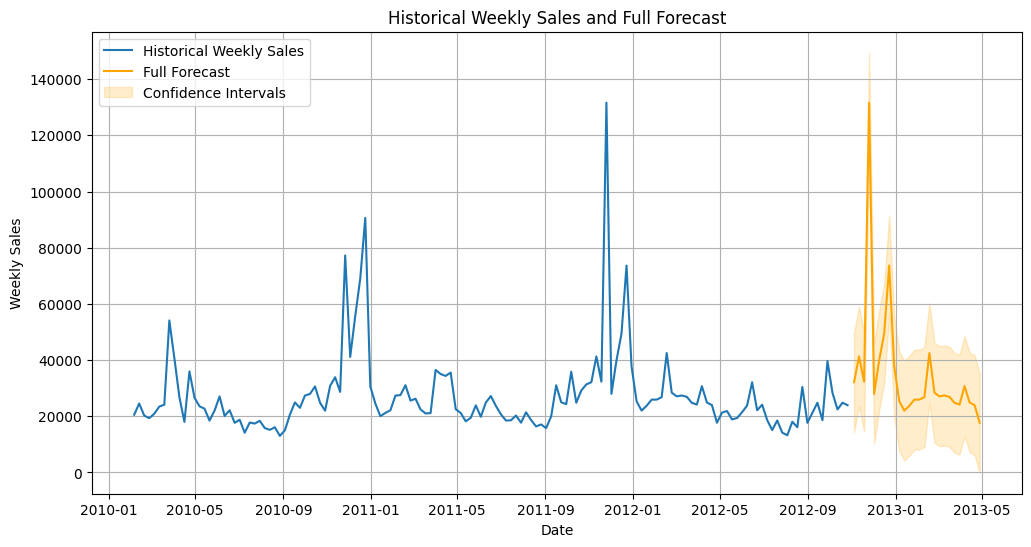

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=11.35 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=2798.820, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=inf, Time=4.36 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=inf, Time=6.11 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=2796.825, Time=0.03 sec
 ARIMA(0,1,0)(1,0,0)[52] intercept   : AIC=inf, Time=2.19 sec
 ARIMA(0,1,0)(0,0,1)[52] intercept   : AIC=inf, Time=5.60 sec
 ARIMA(0,1,0)(1,0,1)[52] intercept   : AIC=2707.089, Time=5.22 sec
 ARIMA(0,1,0)(2,0,1)[52] intercept   : AIC=inf, Time=25.13 sec
 ARIMA(0,1,0)(1,0,2)[52] intercept   : AIC=2710.177, Time=29.86 sec
 ARIMA(0,1,0)(0,0,2)[52] intercept   : AIC=2759.824, Time=7.41 sec
 ARIMA(0,1,0)(2,0,0)[52] intercept   : AIC=inf, Time=13.92 sec
 ARIMA(0,1,0)(2,0,2)[52] intercept   : AIC=inf, Time=32.41 sec
 ARIMA(1,1,0)(1,0,1)[52] intercept   : AIC=2676.874, Time=7.71 sec
 ARIMA(1,1,0)(0,0,1)[52] intercept   : AIC=inf, Time=4

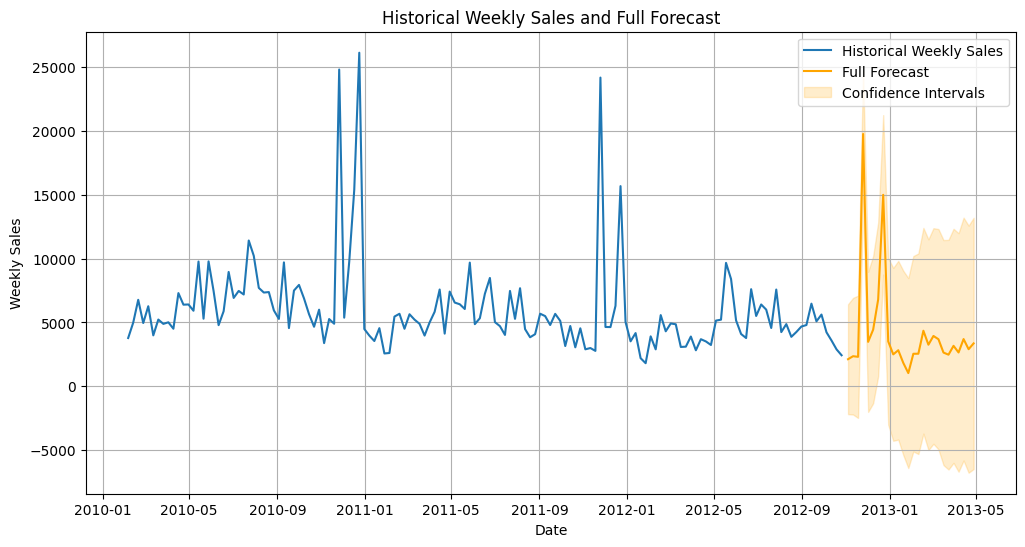

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=3062.294, Time=5.09 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=3130.444, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=3074.232, Time=1.16 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=3066.401, Time=1.03 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=3313.238, Time=0.03 sec
 ARIMA(2,0,2)(0,0,1)[52] intercept   : AIC=3061.403, Time=2.71 sec
 ARIMA(2,0,2)(0,0,0)[52] intercept   : AIC=3070.734, Time=0.12 sec
 ARIMA(2,0,2)(0,0,2)[52] intercept   : AIC=3061.750, Time=12.35 sec
 ARIMA(2,0,2)(1,0,0)[52] intercept   : AIC=3060.312, Time=3.09 sec
 ARIMA(2,0,2)(2,0,0)[52] intercept   : AIC=3062.196, Time=20.18 sec
 ARIMA(2,0,2)(2,0,1)[52] intercept   : AIC=inf, Time=33.66 sec
 ARIMA(1,0,2)(1,0,0)[52] intercept   : AIC=3060.144, Time=3.21 sec
 ARIMA(1,0,2)(0,0,0)[52] intercept   : AIC=3070.325, Time=0.19 sec
 ARIMA(1,0,2)(2,0,0)[52] intercept   : AIC=3061.706, Time=11.54 sec
 ARIMA(1,0,2)(1,0,1)

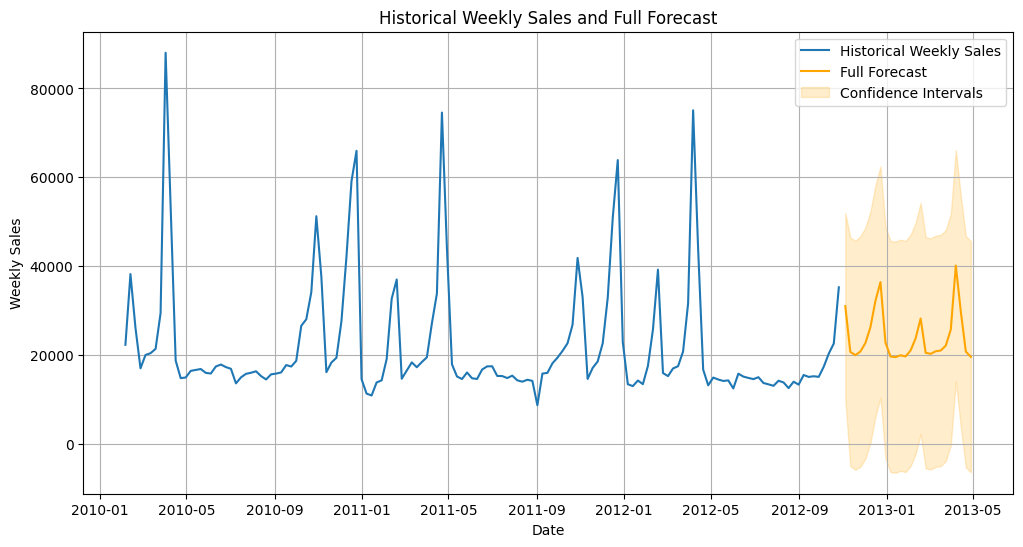

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=9.59 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=2968.746, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=2932.328, Time=0.89 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=2934.120, Time=1.17 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=2966.754, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=2951.291, Time=0.06 sec
 ARIMA(1,1,0)(2,0,0)[52] intercept   : AIC=inf, Time=6.79 sec
 ARIMA(1,1,0)(1,0,1)[52] intercept   : AIC=2931.590, Time=1.99 sec
 ARIMA(1,1,0)(0,0,1)[52] intercept   : AIC=2936.331, Time=0.75 sec
 ARIMA(1,1,0)(2,0,1)[52] intercept   : AIC=2933.294, Time=16.12 sec
 ARIMA(1,1,0)(1,0,2)[52] intercept   : AIC=2933.308, Time=10.57 sec
 ARIMA(1,1,0)(0,0,2)[52] intercept   : AIC=2931.942, Time=4.05 sec
 ARIMA(1,1,0)(2,0,2)[52] intercept   : AIC=2935.296, Time=12.65 sec
 ARIMA(0,1,0)(1,0,1)[52] intercept   : AIC=2953.719, Time=1.55 sec
 ARIMA(2,1,0)(1,0,1)[52] i

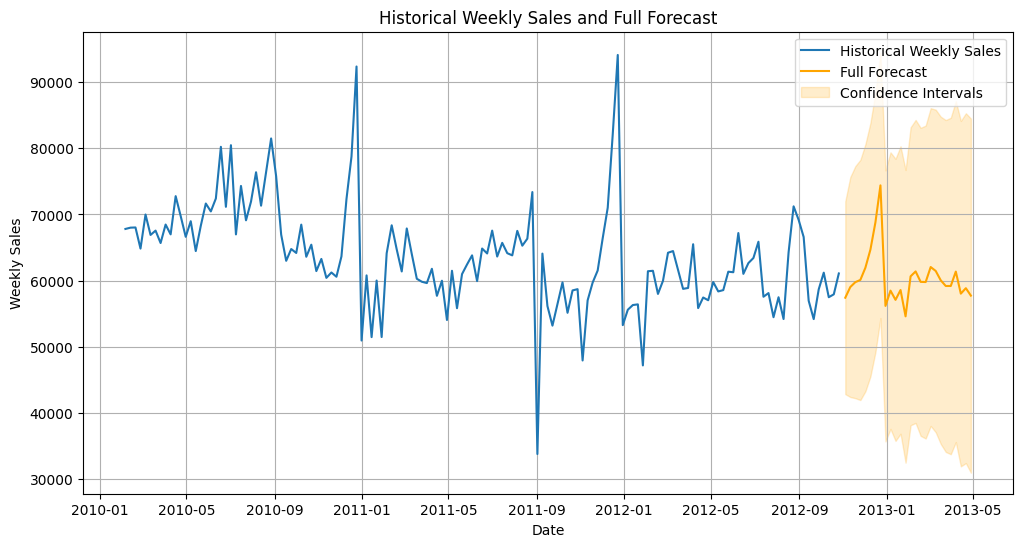

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=2978.048, Time=4.43 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=3129.726, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=2975.310, Time=1.82 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=3046.275, Time=1.03 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=3257.336, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=2993.461, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[52] intercept   : AIC=inf, Time=8.06 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=2976.197, Time=1.53 sec
 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=2983.365, Time=0.85 sec
 ARIMA(1,0,0)(2,0,1)[52] intercept   : AIC=2968.753, Time=9.87 sec
 ARIMA(1,0,0)(3,0,1)[52] intercept   : AIC=inf, Time=124.29 sec
 ARIMA(1,0,0)(2,0,2)[52] intercept   : AIC=2970.606, Time=14.18 sec
 ARIMA(1,0,0)(1,0,2)[52] intercept   : AIC=2969.432, Time=6.49 sec
 ARIMA(1,0,0)(3,0,0)[52] intercept   : AIC=2970.739, Time=21.17 sec
 ARIMA(1,0,0)(3,0,2)[52] 

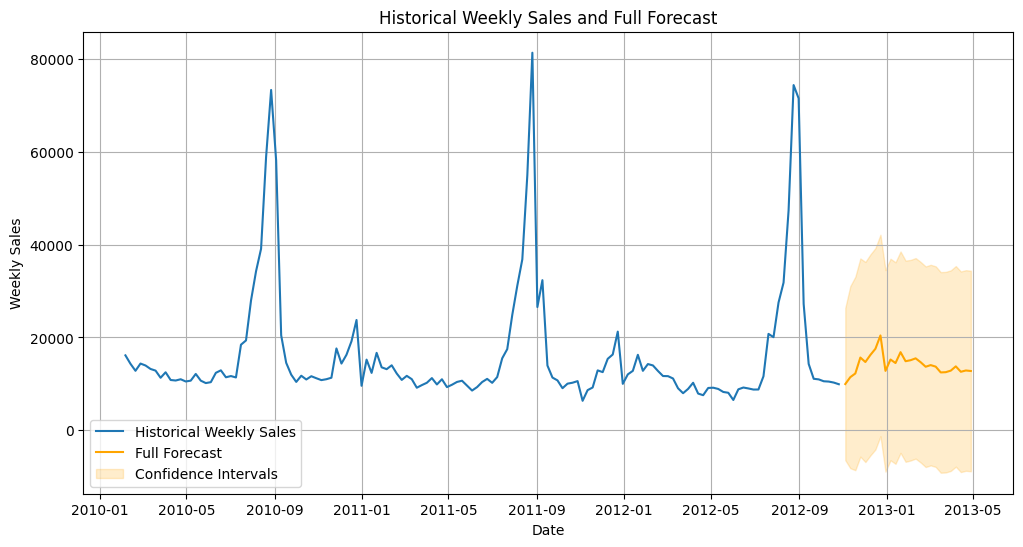

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=2604.939, Time=4.81 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=2626.279, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=2619.504, Time=2.95 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=2623.416, Time=0.81 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=3324.723, Time=0.03 sec
 ARIMA(2,0,2)(0,0,1)[52] intercept   : AIC=2603.031, Time=5.08 sec
 ARIMA(2,0,2)(0,0,0)[52] intercept   : AIC=2603.194, Time=0.18 sec
 ARIMA(2,0,2)(0,0,2)[52] intercept   : AIC=2600.992, Time=17.87 sec
 ARIMA(2,0,2)(1,0,2)[52] intercept   : AIC=2602.624, Time=38.66 sec
 ARIMA(2,0,2)(0,0,3)[52] intercept   : AIC=2602.887, Time=54.48 sec
 ARIMA(2,0,2)(1,0,3)[52] intercept   : AIC=inf, Time=137.15 sec
 ARIMA(1,0,2)(0,0,2)[52] intercept   : AIC=2605.134, Time=12.66 sec
 ARIMA(2,0,1)(0,0,2)[52] intercept   : AIC=2602.813, Time=12.66 sec
 ARIMA(3,0,2)(0,0,2)[52] intercept   : AIC=2602.482, Time=27.25 sec
 ARIMA(2,0,3)(0,

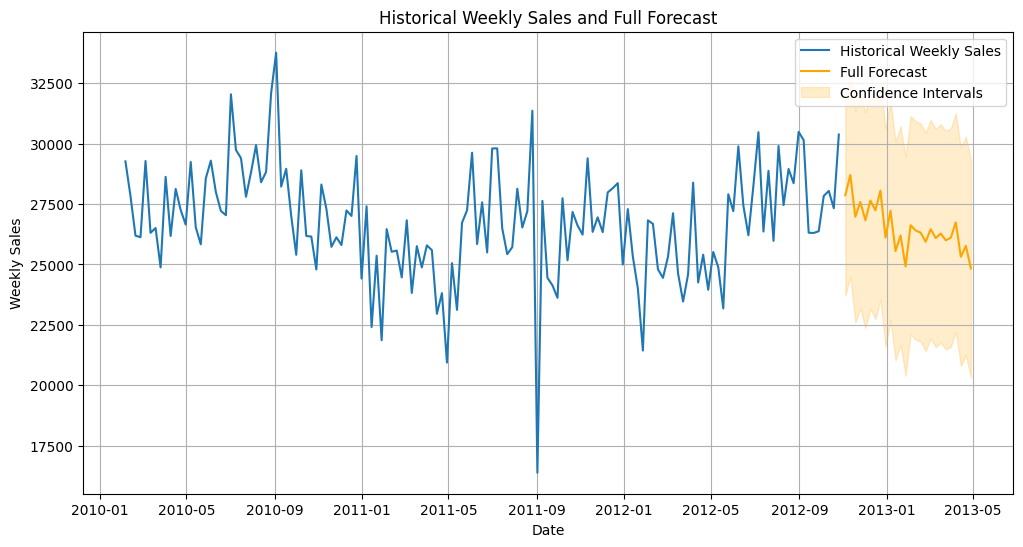

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=3060.300, Time=5.90 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=3153.727, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=3074.130, Time=2.23 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=3099.119, Time=0.86 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=3328.456, Time=0.03 sec
 ARIMA(2,0,2)(0,0,1)[52] intercept   : AIC=3069.365, Time=2.16 sec
 ARIMA(2,0,2)(1,0,0)[52] intercept   : AIC=3058.426, Time=3.42 sec
 ARIMA(2,0,2)(0,0,0)[52] intercept   : AIC=3105.022, Time=0.30 sec
 ARIMA(2,0,2)(2,0,0)[52] intercept   : AIC=3060.394, Time=20.75 sec
 ARIMA(2,0,2)(2,0,1)[52] intercept   : AIC=3061.938, Time=29.81 sec
 ARIMA(1,0,2)(1,0,0)[52] intercept   : AIC=3063.168, Time=2.66 sec
 ARIMA(2,0,1)(1,0,0)[52] intercept   : AIC=3057.403, Time=2.79 sec
 ARIMA(2,0,1)(0,0,0)[52] intercept   : AIC=3104.638, Time=0.12 sec
 ARIMA(2,0,1)(2,0,0)[52] intercept   : AIC=3059.319, Time=17.62 sec
 ARIMA(2,0,1)(1,

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,0,1)(1,0,0)[52]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/pmdarima/arima/arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/pmdarima/arima/arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "/usr/local/lib/python3.10/dist-packages/pmdarima/arima/arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
  File "/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/mlemodel.py", line 703, in fit
    mlefit = super().fit(start_params, method=method,
  File "/usr/local/lib/python3.10/dist-packa

 ARIMA(2,0,1)(1,0,0)[52]             : AIC=inf, Time=nan sec

Best model:  ARIMA(2,0,1)(1,0,0)[52] intercept
Total fit time: 148.688 seconds
Forecasted sales for the next period:
            Weekly_Sales_Forecast      Lower_CI      Upper_CI
Date                                                         
2012-11-04           23713.669800   -171.476101  47598.815700
2012-11-11           28999.159270   2243.211784  55755.106755
2012-11-18           26201.791977  -1779.775267  54183.359221
2012-11-25           65707.412175  37511.924383  93902.899968
2012-12-02           26068.047298  -2288.809378  54424.903974
2012-12-09           32380.717007   4012.990976  60748.443038
2012-12-16           43558.418817  15162.241936  71954.595698
2012-12-23           50507.087057  22110.908935  78903.265180
2012-12-30           21176.960819  -7226.477331  49580.398970
2013-01-06           19752.507033  -8651.693667  48156.707732
2013-01-13           18150.359174 -10256.508259  46557.226607
2013-01-20     

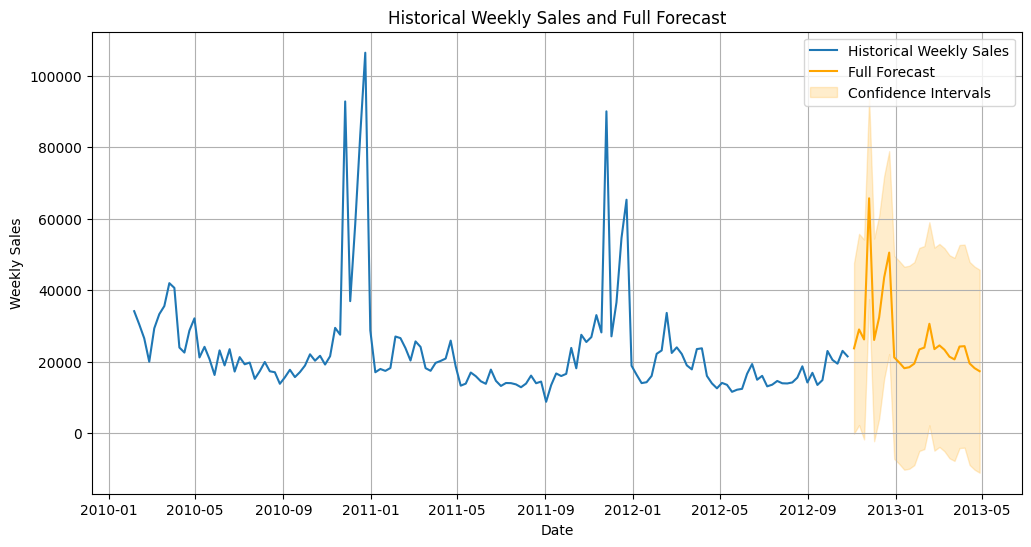

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=12.45 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=2835.240, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=inf, Time=2.59 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=inf, Time=4.38 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=2833.245, Time=0.04 sec
 ARIMA(0,1,0)(1,0,0)[52] intercept   : AIC=inf, Time=4.00 sec
 ARIMA(0,1,0)(0,0,1)[52] intercept   : AIC=inf, Time=4.16 sec
 ARIMA(0,1,0)(1,0,1)[52] intercept   : AIC=2801.194, Time=1.38 sec
 ARIMA(0,1,0)(2,0,1)[52] intercept   : AIC=inf, Time=30.54 sec
 ARIMA(0,1,0)(1,0,2)[52] intercept   : AIC=2803.193, Time=9.41 sec
 ARIMA(0,1,0)(0,0,2)[52] intercept   : AIC=2803.567, Time=5.26 sec
 ARIMA(0,1,0)(2,0,0)[52] intercept   : AIC=inf, Time=27.05 sec
 ARIMA(0,1,0)(2,0,2)[52] intercept   : AIC=inf, Time=48.22 sec
 ARIMA(1,1,0)(1,0,1)[52] intercept   : AIC=2726.213, Time=6.06 sec
 ARIMA(1,1,0)(0,0,1)[52] intercept   : AIC=inf, Time=5.

In [ ]:
for i in range(4,8):
    for j in range(1, 7):
        forecast_sales(df, 'Store', i, 'Dept', j)